# **Installing & Importing**

## Installing

In [ ]:
!pip install Jinja2==3.1.2
!pip install klib
!pip install missingpy

## Importing

In [ ]:
import numpy as np
import pandas as pd
import klib
import warnings

from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn import model_selection 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from collections import Counter
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, CategoricalNB, ComplementNB
from sklearn.svm import SVC
from matplotlib.gridspec import GridSpec
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, accuracy_score,  balanced_accuracy_score
from sklearn import metrics, tree
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import mode

import matplotlib.pyplot as plt
import sys
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

from missingpy import MissForest

warnings.filterwarnings('ignore')

---
# **Skenario 1: Naive Bayes**

## **Klasifikasi NB**

In [ ]:
# Membaca dataset
df = pd.read_csv('hepatitis_csv.csv')
    
# Variabel independen
x = df.drop(['class'], axis=1) # sebagai prediktor

# Variabel dependen
y = df['class'] # sebagai target

# Mengelompokkan data kategorikal dan numerikal berdasarkan dataset
cat_column = ['sex', 'steroid', 'antivirals', 'fatigue', 'malaise', 'anorexia', 
              'liver_big', 'liver_firm', 'spleen_palpable', 'spiders', 'ascites', 
              'varices', 'histology']

num_column = ['age', 'bilirubin', 'alk_phosphate', 'sgot', 'albumin', 'protime']

# Encoding data kategorikal menjadi no = 0 dan yes = 1
cat_pipe = Pipeline([
                     ('encoder',OrdinalEncoder())
])

prepro = ColumnTransformer([
                            ('categorical', cat_pipe, cat_column)
],remainder='passthrough')

prepro.fit(x)
x_encoded = prepro.transform(x)

# menyimpan encoded data to csv
x_pre = pd.DataFrame(x_encoded,columns=cat_column+num_column)
df_pre = x_pre.copy()
df_pre['class'] = y
df_pre.to_excel('hepatitis_pre.xlsx', index=False) #index=False berfungsi untuk tidak menyimpan kolom index

# Drop missing value
x_drop = df_pre.copy()
x_drop = x_drop.dropna() #menghapus baris missing value
y_drop = x_drop['class']
df_drop = x_drop.drop (['class'], axis=1)
df_drop.to_excel('hepatitis_drop.xlsx', index=False)

# Import fungsi split data dengan train_test_split 
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(df_drop, y_drop, test_size=0.5, random_state=75)
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(df_drop, y_drop, test_size=0.4, random_state=75)
x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(df_drop, y_drop, test_size=0.3, random_state=75)

# Memanggil fungsi klasifikasi Naive bayes
gnb = GaussianNB()

# Memasukkan data training pada fungsi klasifikasi naive bayes
y_pred_1 = gnb.fit(x_train_1, y_train_1).predict(x_test_1)
y_pred_2 = gnb.fit(x_train_2, y_train_2).predict(x_test_2)
y_pred_3 = gnb.fit(x_train_3, y_train_3).predict(x_test_3)

# Menampilkan nilai akurasi dari klasifikasi naive bayes
print('Nilai akurasi komposisi 50:50 adalah {:.2f}%'.format(metrics.accuracy_score(y_test_1, y_pred_1)*100))
print('Nilai akurasi komposisi 60:40 adalah {:.2f}%'.format(metrics.accuracy_score(y_test_2, y_pred_2)*100))
print('Nilai akurasi komposisi 70:30 adalah {:.2f}%'.format(metrics.accuracy_score(y_test_3, y_pred_3)*100))

Nilai akurasi komposisi 50:50 adalah 87.50%
Nilai akurasi komposisi 60:40 adalah 87.50%
Nilai akurasi komposisi 70:30 adalah 83.33%


---
## **Confusion Matrix NB**

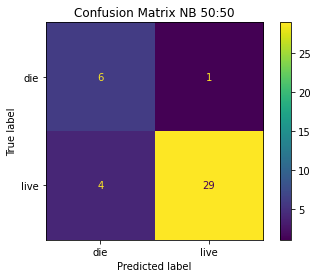

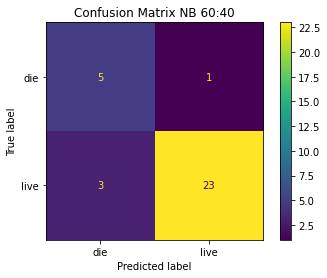

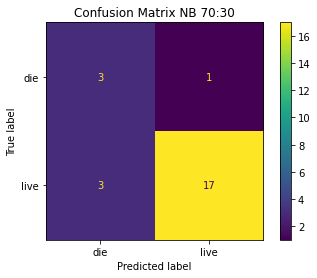

In [ ]:
disp_1 = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix
                                        (y_test_1, y_pred_1), 
                                        display_labels=gnb.classes_)
disp_1.plot()
plt.title('Confusion Matrix NB 50:50')
plt.show()
print ( )

disp_2 = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix
                                        (y_test_2, y_pred_2), 
                                        display_labels=gnb.classes_)
disp_2.plot()
plt.title('Confusion Matrix NB 60:40')
plt.show()
print ( )

disp_3 = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix
                                        (y_test_3, y_pred_3), 
                                        display_labels=gnb.classes_)
disp_3.plot()
plt.title('Confusion Matrix NB 70:30')
plt.show()

---
# **Skenario 2: Naive Bayes + MissForest**



## **Klasifikasi NB+MF**

In [ ]:
# Membaca dataset
df = pd.read_excel('hepatitis_pre.xlsx')

# Variabel independen
x = df.drop(['class'], axis=1) # sebagai prediktor

# Variabel dependen
y = df['class'] # sebagai target

# fitur kategorikal dinyatakan kedalam cat_column
cat_column = ['sex','steroid','antivirals','fatigue','malaise','anorexia',
              'liver_big','liver_firm','spleen_palpable','spiders','ascites',
              'varices','histology']
cat_cols = []
for i in cat_column :
    cat_cols.append(x.columns.to_list().index(i))
# Mengambil index dari list cat_column dan dimasukkan ke cat_cols. Mengubah list cat_column menjadi index dan dimasukkan ke cat_cols

# Imputasi missforest
imputer = MissForest(max_iter=10, #iterasi maksimal sampai 10
                     n_estimators=100, #jumlah pohon yang akan digunakan
                     class_weight='balanced', #meningkatkan bobot kelas minoritas dan mengurangi bobot kelas mayoritas dalam menghitung prediksi
                     random_state=75) #berfungsi agar proses pelatihan model memperoleh hasil yang sama walaupun dijalankan berulang kali
x_imputed = imputer.fit_transform(x, cat_vars=cat_cols) #cat_vars berfungsi sebagai penentu fitur kategorikal pada dataset

# menyimpan data hasil imputasi ke csv
df_imputed = pd.DataFrame(x_imputed, columns=x.columns)
df_imputed['class'] = y
x_imp = df_imputed.drop(['class'], axis=1)
x_imp.to_excel('hepatitis_missforest.xlsx', index=False)

# Import train_test_split func
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(x_imp, y, test_size=0.5, random_state=75)
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(x_imp, y, test_size=0.4, random_state=75)
x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(x_imp, y, test_size=0.3, random_state=75)

# Mengaktifkan/memanggil/membuat fungsi klasifikasi Naive bayes
gnb = GaussianNB()

# Memasukkan data training pada fungsi klasifikasi naive bayes
y_pred_1 = gnb.fit(x_train_1, y_train_1).predict(x_test_1)
y_pred_2 = gnb.fit(x_train_2, y_train_2).predict(x_test_2)
y_pred_3 = gnb.fit(x_train_3, y_train_3).predict(x_test_3)

# Menampilkan nilai akurasi dari klasifikasi naive bayes
print( )
print('Nilai akurasi komposisi 50:50 adalah {:.2f}%'.format(metrics.accuracy_score(y_test_1, y_pred_1)*100))
print('Nilai akurasi komposisi 60:40 adalah {:.2f}%'.format(metrics.accuracy_score(y_test_2, y_pred_2)*100))
print('Nilai akurasi komposisi 70:30 adalah {:.2f}%'.format(metrics.accuracy_score(y_test_3, y_pred_3)*100))

Iteration: 0
Iteration: 1
Iteration: 2

Nilai akurasi komposisi 50:50 adalah 83.33%
Nilai akurasi komposisi 60:40 adalah 90.32%
Nilai akurasi komposisi 70:30 adalah 93.62%


---
## **Confusion Matrix NB+MF**

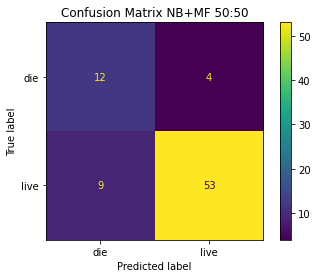

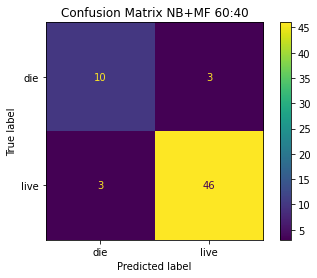

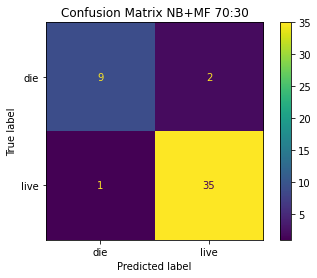

In [ ]:
disp_1 = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix
                                        (y_test_1, y_pred_1), 
                                        display_labels=gnb.classes_)
disp_1.plot()
plt.title('Confusion Matrix NB+MF 50:50')
plt.show()
print( )

disp_2 = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix
                                        (y_test_2, y_pred_2), 
                                        display_labels=gnb.classes_)
disp_2.plot()
plt.title('Confusion Matrix NB+MF 60:40')
plt.show()
print( )

disp_3 = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix
                                        (y_test_3, y_pred_3), 
                                        display_labels=gnb.classes_)
disp_3.plot()
plt.title('Confusion Matrix NB+MF 70:30')
plt.show()

---
#Percobaan

## Classification Report NB

In [ ]:
print('Clasification report NB 50:50')
print(classification_report(y_test_1, y_pred_1))
print('\nClasification report NB 60:40')
print(classification_report(y_test_2, y_pred_2))
print('\nClasification report NB 70:30')
print(classification_report(y_test_3, y_pred_3))

Clasification report NB 50:50
              precision    recall  f1-score   support

         die       0.60      0.86      0.71         7
        live       0.97      0.88      0.92        33

    accuracy                           0.88        40
   macro avg       0.78      0.87      0.81        40
weighted avg       0.90      0.88      0.88        40


Clasification report NB 60:40
              precision    recall  f1-score   support

         die       0.62      0.83      0.71         6
        live       0.96      0.88      0.92        26

    accuracy                           0.88        32
   macro avg       0.79      0.86      0.82        32
weighted avg       0.90      0.88      0.88        32


Clasification report NB 70:30
              precision    recall  f1-score   support

         die       0.50      0.75      0.60         4
        live       0.94      0.85      0.89        20

    accuracy                           0.83        24
   macro avg       0.72      0.80   

## Balanced Accuracy

In [ ]:
# Berbeda dengan accuracy yang menghitung proporsi prediksi benar secara agregat, 
# balanced accuracy mempertimbangkan proporsi prediksi untuk masing-masing kelas. 
# Dalam kasus data tidak seimbang, seringkali nilai balanced accuracy menjadi 
# lebih relevan untuk digunakan

print("Balanced Accuracy 50:50 adalah {:.2f}%".format(metrics.balanced_accuracy_score(y_test_1, y_pred_1)*100))
print("Balanced Accuracy 60:40 adalah {:.2f}%".format(metrics.balanced_accuracy_score(y_test_2, y_pred_2)*100))
print("Balanced Accuracy 70:30 adalah {:.2f}%".format(metrics.balanced_accuracy_score(y_test_3, y_pred_3)*100))

Balanced Accuracy 50:50 adalah 86.80%
Balanced Accuracy 60:40 adalah 85.90%
Balanced Accuracy 70:30 adalah 80.00%


## Classification Report NB+MF

In [ ]:
print('Clasification report NB+MF 50:50')
print(classification_report(y_test_1, y_pred_1))
print('\nClasification report NB+MF 60:40')
print(classification_report(y_test_2, y_pred_2))
print('\nClasification report NB+MF 70:30')
print(classification_report(y_test_3, y_pred_3))

Clasification report NB+MF 50:50
              precision    recall  f1-score   support

         die       0.57      0.75      0.65        16
        live       0.93      0.85      0.89        62

    accuracy                           0.83        78
   macro avg       0.75      0.80      0.77        78
weighted avg       0.86      0.83      0.84        78


Clasification report NB+MF 60:40
              precision    recall  f1-score   support

         die       0.77      0.77      0.77        13
        live       0.94      0.94      0.94        49

    accuracy                           0.90        62
   macro avg       0.85      0.85      0.85        62
weighted avg       0.90      0.90      0.90        62


Clasification report NB+MF 70:30
              precision    recall  f1-score   support

         die       0.90      0.82      0.86        11
        live       0.95      0.97      0.96        36

    accuracy                           0.94        47
   macro avg       0.92    

## Balanced Accuracy

In [ ]:
print("Balanced Accuracy 50:50 adalah {:.2f}%".format(metrics.balanced_accuracy_score(y_test_1, y_pred_1)*100))
print("Balanced Accuracy 60:40 adalah {:.2f}%".format(metrics.balanced_accuracy_score(y_test_2, y_pred_2)*100))
print("Balanced Accuracy 70:30 adalah {:.2f}%".format(metrics.balanced_accuracy_score(y_test_3, y_pred_3)*100))

Balanced Accuracy 50:50 adalah 80.24%
Balanced Accuracy 60:40 adalah 85.40%
Balanced Accuracy 70:30 adalah 89.52%


##Preprocessing NB

###one hot

In [ ]:
# Membaca dataset
hepatitis = pd.read_csv('/content/drive/MyDrive/dataset/hepatitis_csv.csv')

# Variabel independen
x = hepatitis.drop (["class"], axis = 1)
x.head()

# Variabel dependen
y = hepatitis ["class"]
y.head()

cat_column = ['sex', 'steroid', 'antivirals', 'fatigue', 'malaise', 'anorexia', 
              'liver_big', 'liver_firm', 'spleen_palpable', 'spiders', 'ascites', 
              'varices', 'histology']
num_column = ['age', 'bilirubin', 'alk_phosphate', 'sgot', 'albumin', 'protime']

#Encoding data kategorikal
from sklearn.preprocessing import OneHotEncoder
cat_pipe = Pipeline([
                     ("encoder",OneHotEncoder(sparse=False))
])

prepro = ColumnTransformer([
                            ("categorical", cat_pipe, cat_column)
],remainder="passthrough")

prepro.fit(x)
x_encoded = prepro.transform(x)

# Save encoded data to csv
# x_pre = pd.DataFrame(x_encoded,columns=cat_column+num_column)
x_pre = pd.DataFrame(x_encoded)
df_pre = x_pre.copy()
df_pre['class'] = y
df_pre.to_csv('/content/drive/MyDrive/dataset/hepatitis_pre.csv')

# Drop missing value
x_dropna = df_pre.copy()
x_dropna = x_dropna.dropna()
y_dropna = x_dropna['class']
x_dropna = x_dropna.drop (["class"], axis = 1)
x_dropna.to_csv('/content/drive/MyDrive/dataset/hepatitis_dropna.csv')

# Mengaktifkan/memanggil/membuat fungsi klasifikasi Naive bayes
modelnb = GaussianNB()

# Import train_test_split function
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(x_dropna, y_dropna, test_size = 0.5, random_state = 42)
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(x_dropna, y_dropna, test_size = 0.4, random_state = 42)
x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(x_dropna, y_dropna, test_size = 0.3, random_state = 42)
x_train_4, x_test_4, y_train_4, y_test_4 = train_test_split(x_dropna, y_dropna, test_size = 0.2, random_state = 42)
x_train_5, x_test_5, y_train_5, y_test_5 = train_test_split(x_dropna, y_dropna, test_size = 0.1, random_state = 42)

# Memasukkan data training pada fungsi klasifikasi naive bayes
y_pred_1 = modelnb.fit(x_train_1, y_train_1).predict(x_test_1)
y_pred_2 = modelnb.fit(x_train_2, y_train_2).predict(x_test_2)
y_pred_3 = modelnb.fit(x_train_3, y_train_3).predict(x_test_3)
y_pred_4 = modelnb.fit(x_train_4, y_train_4).predict(x_test_4)
y_pred_5 = modelnb.fit(x_train_5, y_train_5).predict(x_test_5)

# Menampilkan nilai akurasi dari klasifikasi naive bayes
print("Nilai akurasi komposisi 50:50 adalah {:.2f}%".format(metrics.accuracy_score(y_test_1, y_pred_1) * 100))
print("Nilai akurasi komposisi 60:40 adalah {:.2f}%".format(metrics.accuracy_score(y_test_2, y_pred_2) * 100))
print("Nilai akurasi komposisi 70:30 adalah {:.2f}%".format(metrics.accuracy_score(y_test_3, y_pred_3) * 100))
print("Nilai akurasi komposisi 80:20 adalah {:.2f}%".format(metrics.accuracy_score(y_test_4, y_pred_4) * 100))
print("Nilai akurasi komposisi 90:10 adalah {:.2f}%".format(metrics.accuracy_score(y_test_5, y_pred_5) * 100))

Nilai akurasi komposisi 50:50 adalah 76.19%
Nilai akurasi komposisi 60:40 adalah 79.41%
Nilai akurasi komposisi 70:30 adalah 96.00%
Nilai akurasi komposisi 80:20 adalah 100.00%
Nilai akurasi komposisi 90:10 adalah 100.00%


###label

In [ ]:
# Membaca dataset
hepatitis = pd.read_csv('hepatitis_csv.csv')

# Variabel independen
x = hepatitis.drop (['class'], axis = 1)

# Variabel dependen
y = hepatitis ['class']

from sklearn.preprocessing import LabelEncoder

x_encoded = x[['sex','steroid','antivirals','fatigue','malaise','anorexia',
               'liver_big','liver_firm','spleen_palpable','spiders','ascites',
               'varices','histology']].apply(LabelEncoder().fit_transform).copy()
x_encoded = x_encoded.join(x[['age','bilirubin','alk_phosphate','sgot','albumin',
                              'protime']])

# Save encoded data to csv
x_pre = pd.DataFrame(x_encoded,columns=cat_column+num_column)
df_pre = x_pre.copy()
df_pre['class'] = y
df_pre.to_csv('hepatitis_pre.csv')

# Drop missing value
x_drop = df_pre.copy()
x_drop = x_drop.dropna()
y_drop = x_drop['class']
x_dropna = x_drop.drop (['class'], axis = 1)
x_dropna.to_csv('hepatitis_dropna.csv')

# Mengaktifkan/memanggil/membuat fungsi klasifikasi Naive bayes
modelnb = GaussianNB()

# Import train_test_split function
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(x_dropna, y_drop, test_size = 0.5, random_state = 42)
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(x_dropna, y_drop, test_size = 0.4, random_state = 42)
x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(x_dropna, y_drop, test_size = 0.3, random_state = 42)

# Memasukkan data training pada fungsi klasifikasi naive bayes
y_pred_1 = modelnb.fit(x_train_1, y_train_1).predict(x_test_1)
y_pred_2 = modelnb.fit(x_train_2, y_train_2).predict(x_test_2)
y_pred_3 = modelnb.fit(x_train_3, y_train_3).predict(x_test_3)

# Menampilkan nilai akurasi dari klasifikasi naive bayes
print("Nilai akurasi komposisi 50:50 adalah {:.2f}%".format(metrics.accuracy_score(y_test_1, y_pred_1) * 100))
print("Nilai akurasi komposisi 60:40 adalah {:.2f}%".format(metrics.accuracy_score(y_test_2, y_pred_2) * 100))
print("Nilai akurasi komposisi 70:30 adalah {:.2f}%".format(metrics.accuracy_score(y_test_3, y_pred_3) * 100))

Nilai akurasi komposisi 50:50 adalah 78.57%
Nilai akurasi komposisi 60:40 adalah 79.41%
Nilai akurasi komposisi 70:30 adalah 100.00%


### ordinal + stratify

In [ ]:
# Membaca dataset
hepatitis = pd.read_csv('hepatitis_csv.csv')

# Variabel independen
x = hepatitis.drop (['class'], axis = 1)

# Variabel dependen
y = hepatitis ['class']

cat_column = ['sex', 'steroid', 'antivirals', 'fatigue', 'malaise', 'anorexia', 
              'liver_big', 'liver_firm', 'spleen_palpable', 'spiders', 'ascites', 
              'varices', 'histology']
num_column = ['age', 'bilirubin', 'alk_phosphate', 'sgot', 'albumin', 'protime']

#Encoding data kategorikal
cat_pipe = Pipeline([
                     ('encoder',OrdinalEncoder())
])

prepro = ColumnTransformer([
                            ('categorical', cat_pipe, cat_column)
],remainder='passthrough')

prepro.fit(x)
x_encoded = prepro.transform(x)

# Save encoded data to csv
x_pre = pd.DataFrame(x_encoded,columns=cat_column+num_column)
df_pre = x_pre.copy()
df_pre['class'] = y
df_pre.to_csv('hepatitis_pre.csv')

# Drop missing value
x_dropna = df_pre.copy()
x_dropna = x_dropna.dropna()
y_dropna = x_dropna['class']
x_dropna = x_dropna.drop (['class'], axis = 1)
x_dropna.to_csv('hepatitis_dropna.csv')

# Import train_test_split function
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(x_dropna, y_dropna, test_size = 0.5, stratify=y_dropna, random_state = 75)
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(x_dropna, y_dropna, test_size = 0.4, stratify=y_dropna, random_state = 75)
x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(x_dropna, y_dropna, test_size = 0.3, stratify=y_dropna, random_state = 75)

# Memasukkan data training pada fungsi klasifikasi naive bayes
y_pred_1 = modelnb.fit(x_train_1, y_train_1).predict(x_test_1)
y_pred_2 = modelnb.fit(x_train_2, y_train_2).predict(x_test_2)
y_pred_3 = modelnb.fit(x_train_3, y_train_3).predict(x_test_3)

# Menampilkan nilai akurasi dari klasifikasi naive bayes
print("Nilai akurasi komposisi 50:50 adalah {:.2f}%".format(metrics.accuracy_score(y_test_1, y_pred_1) * 100))
print("Nilai akurasi komposisi 60:40 adalah {:.2f}%".format(metrics.accuracy_score(y_test_2, y_pred_2) * 100))
print("Nilai akurasi komposisi 70:30 adalah {:.2f}%".format(metrics.accuracy_score(y_test_3, y_pred_3) * 100))

Nilai akurasi komposisi 50:50 adalah 87.50%
Nilai akurasi komposisi 60:40 adalah 84.38%
Nilai akurasi komposisi 70:30 adalah 91.67%


###one hot + stratify

In [ ]:
# Membaca dataset
hepatitis = pd.read_csv('hepatitis_csv.csv')

# Variabel independen
x = hepatitis.drop (['class'], axis = 1)

# Variabel dependen
y = hepatitis ['class']

cat_column = ['sex', 'steroid', 'antivirals', 'fatigue', 'malaise', 'anorexia', 
              'liver_big', 'liver_firm', 'spleen_palpable', 'spiders', 'ascites', 
              'varices', 'histology']
num_column = ['age', 'bilirubin', 'alk_phosphate', 'sgot', 'albumin', 'protime']

#Encoding data kategorikal
from sklearn.preprocessing import OneHotEncoder
cat_pipe = Pipeline([
                     ('encoder',OneHotEncoder(sparse=False))
])

prepro = ColumnTransformer([
                            ('categorical', cat_pipe, cat_column)
],remainder='passthrough')

prepro.fit(x)
x_encoded = prepro.transform(x)

# Save encoded data to csv
# x_pre = pd.DataFrame(x_encoded,columns=cat_column+num_column)
x_pre = pd.DataFrame(x_encoded)
df_pre = x_pre.copy()
df_pre['class'] = y
df_pre.to_csv('hepatitis_pre.csv')

# Drop missing value
x_dropna = df_pre.copy()
x_dropna = x_dropna.dropna()
y_dropna = x_dropna['class']
x_dropna = x_dropna.drop (['class'], axis = 1)
x_dropna.to_csv('hepatitis_dropna.csv')

# # normalisasi data
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# scaler.fit(x_train_1)
# scaler.fit(x_train_2)
# scaler.fit(x_train_3)
# scaler.fit(x_train_4)
# scaler.fit(x_train_5)

# x_train_scl1= scaler.transform(x_train_1)
# x_test_scl2= scaler.transform(x_test_1)
# x_train_scl2= scaler.transform(x_train_2)
# x_test_scl2= scaler.transform(x_test_2)
# x_train_scl3= scaler.transform(x_train_3)
# X_test_scl3= scaler.transform(x_test_3)
# x_train_scl4= scaler.transform(x_train_4)
# X_test_scl4= scaler.transform(x_test_4)
# x_train_scl5= scaler.transform(x_train_5)
# x_test_scl5= scaler.transform(x_test_5)

#Penyeimbangan Data
# from imblearn.over_sampling import SMOTENC
# cat_cols = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 
#             19, 20, 21, 22, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]
# smote_nc = SMOTENC(categorical_features=cat_cols, random_state=42, k_neighbors=4)
# from imblearn.over_sampling import SMOTE
# smote = SMOTE(random_state=42, k_neighbors=4)
# x_res_1, y_res_1 = smote.fit_resample(x_train_scl1, y_train_1)
# x_res_2, y_res_2 = smote.fit_resample(x_train_scl2, y_train_2)
# x_res_3, y_res_3 = smote.fit_resample(x_train_scl3, y_train_3)
# x_res_4, y_res_4 = smote.fit_resample(x_train_scl4, y_train_4)
# x_res_5, y_res_5 = smote.fit_resample(x_train_scl5, y_train_5)

# Mengaktifkan/memanggil/membuat fungsi klasifikasi Naive bayes
modelnb = GaussianNB()

# Import train_test_split function
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(x_dropna, y_dropna, test_size = 0.5, stratify=y_dropna, random_state = 42)
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(x_dropna, y_dropna, test_size = 0.4, stratify=y_dropna, random_state = 42)
x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(x_dropna, y_dropna, test_size = 0.3, stratify=y_dropna, random_state = 42)
x_train_4, x_test_4, y_train_4, y_test_4 = train_test_split(x_dropna, y_dropna, test_size = 0.2, stratify=y_dropna, random_state = 42)
x_train_5, x_test_5, y_train_5, y_test_5 = train_test_split(x_dropna, y_dropna, test_size = 0.1, stratify=y_dropna, random_state = 42)

# Memasukkan data training pada fungsi klasifikasi naive bayes
y_pred_1 = modelnb.fit(x_train_1, y_train_1).predict(x_test_1)
y_pred_2 = modelnb.fit(x_train_2, y_train_2).predict(x_test_2)
y_pred_3 = modelnb.fit(x_train_3, y_train_3).predict(x_test_3)
y_pred_4 = modelnb.fit(x_train_4, y_train_4).predict(x_test_4)
y_pred_5 = modelnb.fit(x_train_5, y_train_5).predict(x_test_5)

# Menampilkan nilai akurasi dari klasifikasi naive bayes
print("Nilai akurasi komposisi 50:50 adalah {:.2f}%".format(metrics.accuracy_score(y_test_1, y_pred_1) * 100))
print("Nilai akurasi komposisi 60:40 adalah {:.2f}%".format(metrics.accuracy_score(y_test_2, y_pred_2) * 100))
print("Nilai akurasi komposisi 70:30 adalah {:.2f}%".format(metrics.accuracy_score(y_test_3, y_pred_3) * 100))
print("Nilai akurasi komposisi 80:20 adalah {:.2f}%".format(metrics.accuracy_score(y_test_4, y_pred_4) * 100))
print("Nilai akurasi komposisi 90:10 adalah {:.2f}%".format(metrics.accuracy_score(y_test_5, y_pred_5) * 100))

Nilai akurasi komposisi 50:50 adalah 80.95%
Nilai akurasi komposisi 60:40 adalah 85.29%
Nilai akurasi komposisi 70:30 adalah 88.00%
Nilai akurasi komposisi 80:20 adalah 88.24%
Nilai akurasi komposisi 90:10 adalah 88.89%


###label + stratify

In [ ]:
# Membaca dataset
hepatitis = pd.read_csv('hepatitis_csv.csv')

# Variabel independen
x = hepatitis.drop (["class"], axis = 1)
x.head()

# Variabel dependen
y = hepatitis ["class"]
y.head()

from sklearn.preprocessing import LabelEncoder

x_encoded = x[['sex','steroid','antivirals','fatigue','malaise','anorexia',
               'liver_big','liver_firm','spleen_palpable','spiders','ascites',
               'varices','histology']].apply(LabelEncoder().fit_transform).copy()
x_encoded = x_encoded.join(x[['age','bilirubin','alk_phosphate','sgot','albumin',
                              'protime']])

# Save encoded data to csv
x_pre = pd.DataFrame(x_encoded,columns=cat_column+num_column)
df_pre = x_pre.copy()
df_pre['class'] = y
df_pre.to_csv('hepatitis_pre.csv')

# Drop missing value
x_dropna = df_pre.copy()
x_dropna = x_dropna.dropna()
y_dropna = x_dropna['class']
x_dropna = x_dropna.drop (["class"], axis = 1)
x_dropna.to_csv('hepatitis_dropna.csv')

# Mengaktifkan/memanggil/membuat fungsi klasifikasi Naive bayes
modelnb = GaussianNB()

# Import train_test_split function
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(x_dropna, y_dropna, test_size = 0.5, stratify=y_dropna, random_state = 42)
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(x_dropna, y_dropna, test_size = 0.4, stratify=y_dropna, random_state = 42)
x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(x_dropna, y_dropna, test_size = 0.3, stratify=y_dropna, random_state = 42)
x_train_4, x_test_4, y_train_4, y_test_4 = train_test_split(x_dropna, y_dropna, test_size = 0.2, stratify=y_dropna, random_state = 42)
x_train_5, x_test_5, y_train_5, y_test_5 = train_test_split(x_dropna, y_dropna, test_size = 0.1, stratify=y_dropna, random_state = 42)

# Memasukkan data training pada fungsi klasifikasi naive bayes
y_pred_1 = modelnb.fit(x_train_1, y_train_1).predict(x_test_1)
y_pred_2 = modelnb.fit(x_train_2, y_train_2).predict(x_test_2)
y_pred_3 = modelnb.fit(x_train_3, y_train_3).predict(x_test_3)
y_pred_4 = modelnb.fit(x_train_4, y_train_4).predict(x_test_4)
y_pred_5 = modelnb.fit(x_train_5, y_train_5).predict(x_test_5)

# Menampilkan nilai akurasi dari klasifikasi naive bayes
print("Nilai akurasi komposisi 50:50 adalah {:.2f}%".format(metrics.accuracy_score(y_test_1, y_pred_1) * 100))
print("Nilai akurasi komposisi 60:40 adalah {:.2f}%".format(metrics.accuracy_score(y_test_2, y_pred_2) * 100))
print("Nilai akurasi komposisi 70:30 adalah {:.2f}%".format(metrics.accuracy_score(y_test_3, y_pred_3) * 100))
print("Nilai akurasi komposisi 80:20 adalah {:.2f}%".format(metrics.accuracy_score(y_test_4, y_pred_4) * 100))
print("Nilai akurasi komposisi 90:10 adalah {:.2f}%".format(metrics.accuracy_score(y_test_5, y_pred_5) * 100))

Nilai akurasi komposisi 50:50 adalah 80.95%
Nilai akurasi komposisi 60:40 adalah 82.35%
Nilai akurasi komposisi 70:30 adalah 88.00%
Nilai akurasi komposisi 80:20 adalah 88.24%
Nilai akurasi komposisi 90:10 adalah 88.89%


### Penyeimbangan data

#### Standar + SMOTE

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

x_train_scl1 = sc.fit_transform(x_train_1)
x_test_scl1  = sc.fit_transform(x_test_1)
x_train_scl2 = sc.fit_transform(x_train_2)
x_test_scl2  = sc.fit_transform(x_test_2)
x_train_scl3 = sc.fit_transform(x_train_3)
x_test_scl3  = sc.fit_transform(x_test_3)

from imblearn.over_sampling import SMOTE, ADASYN
smote = SMOTE()
x_res_1, y_res_1 = smote.fit_resample(x_train_scl1, y_train_1)
x_res_2, y_res_2 = smote.fit_resample(x_train_scl2, y_train_2)
x_res_3, y_res_3 = smote.fit_resample(x_train_scl3, y_train_3)

gnb = GaussianNB()
gnb.fit(x_res_1, y_res_1)
gnb.fit(x_res_2, y_res_2)
gnb.fit(x_res_3, y_res_3)

y_pred_1 = gnb.predict(x_test_1)
y_pred_2 = gnb.predict(x_test_2)
y_pred_3 = gnb.predict(x_test_3)

print("Nilai akurasi komposisi 50:50 adalah {:.2f}%".format(metrics.accuracy_score(y_test_1, y_pred_1) * 100))
print("Nilai akurasi komposisi 60:40 adalah {:.2f}%".format(metrics.accuracy_score(y_test_2, y_pred_2) * 100))
print("Nilai akurasi komposisi 70:30 adalah {:.2f}%".format(metrics.accuracy_score(y_test_3, y_pred_3) * 100))

Nilai akurasi komposisi 50:50 adalah 82.50%
Nilai akurasi komposisi 60:40 adalah 81.25%
Nilai akurasi komposisi 70:30 adalah 83.33%


#### MinMax + SMOTE

In [ ]:
# Membaca dataset
df = pd.read_excel('hepatitis_drop.xlsx')

# normalisasi data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaler.fit(x_train_1)
scaler.fit(x_train_2)
scaler.fit(x_train_3)

x_train_scl1 = scaler.transform(x_train_1)
x_test_scl1  = scaler.transform(x_test_1)
x_train_scl2 = scaler.transform(x_train_2)
x_test_scl2  = scaler.transform(x_test_2)
x_train_scl3 = scaler.transform(x_train_3)
x_test_scl3  = scaler.transform(x_test_2)

#Penyeimbangan Data
from imblearn.over_sampling import SMOTE, ADASYN

smote = SMOTE()
x_res_1, y_res_1 = smote.fit_resample(x_train_scl1, y_train_1)
x_res_2, y_res_2 = smote.fit_resample(x_train_scl2, y_train_2)
x_res_3, y_res_3 = smote.fit_resample(x_train_scl3, y_train_3)

# ada = ADASYN()
# x_res_1, y_res_1 = ada.fit_resample(x_train_scl1, y_train_1)
# x_res_2, y_res_2 = ada.fit_resample(x_train_scl2, y_train_2)
# x_res_3, y_res_3 = ada.fit_resample(x_train_scl3, y_train_3)

x_im = pd.DataFrame(x_drop,columns=cat_column+num_column)
df_im = x_im.copy()
df_im['class'] = y
df_im.to_excel('hepatitis_imnb.xlsx', index=False)

# Memasukkan data training pada fungsi klasifikasi naive bayes
y_pred_1 = gnb.fit(x_res_1, y_res_1).predict(x_test_1)
y_pred_2 = gnb.fit(x_res_2, y_res_2).predict(x_test_2)
y_pred_3 = gnb.fit(x_res_3, y_res_3).predict(x_test_3)

# Menghitung nilai akurasi dari klasifikasi naive bayes 
print( )
print("Nilai akurasi komposisi 50:50 adalah {:.2f}%".format(metrics.accuracy_score(y_test_1, y_pred_1) * 100))
print("Nilai akurasi komposisi 60:40 adalah {:.2f}%".format(metrics.accuracy_score(y_test_2, y_pred_2) * 100))
print("Nilai akurasi komposisi 70:30 adalah {:.2f}%".format(metrics.accuracy_score(y_test_3, y_pred_3) * 100))


Nilai akurasi komposisi 50:50 adalah 82.50%
Nilai akurasi komposisi 60:40 adalah 81.25%
Nilai akurasi komposisi 70:30 adalah 83.33%


###Cek data oversampling

In [ ]:
print("data train_1 : ", Counter(y_train_1))
print("data test_1  : ", Counter(y_test_1))
print("DATA TOTAL 1 : ", Counter(y_train_1)+Counter(y_test_1), '\n')

print("data train_2 : ", Counter(y_train_2))
print("data test_2  : ", Counter(y_test_2))
print("DATA TOTAL 2 : ", Counter(y_train_2)+Counter(y_test_2), '\n')

print("data train_3 : ", Counter(y_train_3))
print("data test_3  : ", Counter(y_test_3))
print("DATA TOTAL 3 : ", Counter(y_train_3)+Counter(y_test_3))

data train_1 :  Counter({'live': 34, 'die': 6})
data test_1  :  Counter({'live': 33, 'die': 7})
DATA TOTAL 1 :  Counter({'live': 67, 'die': 13}) 

data train_2 :  Counter({'live': 41, 'die': 7})
data test_2  :  Counter({'live': 26, 'die': 6})
DATA TOTAL 2 :  Counter({'live': 67, 'die': 13}) 

data train_3 :  Counter({'live': 47, 'die': 9})
data test_3  :  Counter({'live': 20, 'die': 4})
DATA TOTAL 3 :  Counter({'live': 67, 'die': 13})


In [ ]:
print("Sebelum oversampling, label live : {}".format(sum(y_train_1=='live')))
print("Sebelum oversampling, label die : {}\n".format(sum(y_train_1=='die')))

print("sesudah oversampling, label live : {}".format(sum(y_res_1=='live')))
print("sesudah oversampling, label die : {}".format(sum(y_res_1=='die')))

Sebelum oversampling, label live : 34
Sebelum oversampling, label die : 6

sesudah oversampling, label live : 34
sesudah oversampling, label die : 34


###Data latih

####latih 1 50:50

In [ ]:
print("label live : {}".format(sum(y_train_1=='live')))
print("label die  : {}\n".format(sum(y_train_1=='die')))

train1 = x_train_1
train1

label live : 34
label die  : 6



,sex,steroid,antivirals,fatigue,malaise,anorexia,liver_big,liver_firm,spleen_palpable,spiders,ascites,varices,histology,age,bilirubin,alk_phosphate,sgot,albumin,protime
38,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,42.0,1.0,85.0,14.0,4.0,100.0
104,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,47.0,1.7,86.0,20.0,2.1,46.0
10,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,39.0,1.3,78.0,30.0,4.4,85.0
82,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.7,100.0,31.0,4.0,100.0
137,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,38.0,1.6,130.0,140.0,3.5,56.0
81,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,0.7,62.0,224.0,4.2,100.0
130,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,54.0,1.0,85.0,30.0,4.5,0.0
17,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,40.0,0.6,62.0,166.0,4.0,63.0
129,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,57.0,4.6,82.0,55.0,3.3,30.0
90,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,50.0,0.9,230.0,117.0,3.4,41.0


####latih 2 60:40

In [ ]:
print("label live : {}".format(sum(y_train_2=='live')))
print("label die  : {}\n".format(sum(y_train_2=='die')))

train2 = x_train_2
train2

label live : 41
label die  : 7



,sex,steroid,antivirals,fatigue,malaise,anorexia,liver_big,liver_firm,spleen_palpable,spiders,ascites,varices,histology,age,bilirubin,alk_phosphate,sgot,albumin,protime
96,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,30.0,0.8,147.0,128.0,3.9,100.0
43,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0,0.7,71.0,18.0,4.4,100.0
15,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,38.0,2.0,72.0,89.0,2.9,46.0
23,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,42.0,0.9,60.0,63.0,4.7,47.0
64,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,49.0,0.8,103.0,43.0,3.5,66.0
127,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,50.0,2.8,155.0,75.0,2.4,32.0
125,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,34.0,0.7,70.0,24.0,4.1,100.0
54,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.7,50.0,78.0,4.2,74.0
38,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,42.0,1.0,85.0,14.0,4.0,100.0
104,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,47.0,1.7,86.0,20.0,2.1,46.0


####latih 3 70:30

In [ ]:
print("label live : {}".format(sum(y_train_3=='live')))
print("label die  : {}\n".format(sum(y_train_3=='die')))

train3 = x_train_3
train3

label live : 47
label die  : 9



,sex,steroid,antivirals,fatigue,malaise,anorexia,liver_big,liver_firm,spleen_palpable,spiders,ascites,varices,histology,age,bilirubin,alk_phosphate,sgot,albumin,protime
94,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,59.0,1.5,107.0,157.0,3.6,38.0
84,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,62.0,1.3,141.0,156.0,3.9,58.0
12,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,41.0,0.9,81.0,60.0,3.9,52.0
121,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,20.0,1.0,160.0,118.0,2.9,23.0
143,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,49.0,1.4,85.0,70.0,3.5,35.0
13,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,30.0,2.2,57.0,144.0,4.9,78.0
20,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,0.9,48.0,20.0,4.2,64.0
108,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,54.0,1.0,155.0,225.0,3.6,67.0
96,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,30.0,0.8,147.0,128.0,3.9,100.0
43,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0,0.7,71.0,18.0,4.4,100.0


###Data tes

####tes 1 50:50

In [ ]:
print("label live : {}".format(sum(y_test_1=='live')))
print("label die  : {}\n".format(sum(y_test_1=='die')))

tes1 = x_test_1
tes1

label live : 33
label die  : 7



,sex,steroid,antivirals,fatigue,malaise,anorexia,liver_big,liver_firm,spleen_palpable,spiders,ascites,varices,histology,age,bilirubin,alk_phosphate,sgot,albumin,protime
18,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,38.0,0.7,53.0,42.0,4.1,85.0
63,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,36.0,0.7,164.0,44.0,3.1,41.0
68,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,39.0,1.0,34.0,15.0,4.0,54.0
52,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,44.0,0.6,110.0,145.0,4.4,70.0
36,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,23.0,1.3,194.0,150.0,4.1,90.0
145,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,31.0,1.2,75.0,173.0,4.2,54.0
24,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,0.4,45.0,18.0,4.3,70.0
11,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,32.0,1.0,59.0,249.0,3.7,54.0
138,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,47.0,1.0,166.0,30.0,2.6,31.0
109,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,33.0,0.7,63.0,80.0,3.0,31.0


####tes 2 60:40

In [ ]:
print("label live : {}".format(sum(y_test_2=='live')))
print("label die  : {}\n".format(sum(y_test_2=='die')))

tes2 = x_test_2
tes2

label live : 26
label die  : 6



,sex,steroid,antivirals,fatigue,malaise,anorexia,liver_big,liver_firm,spleen_palpable,spiders,ascites,varices,histology,age,bilirubin,alk_phosphate,sgot,albumin,protime
18,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,38.0,0.7,53.0,42.0,4.1,85.0
63,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,36.0,0.7,164.0,44.0,3.1,41.0
68,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,39.0,1.0,34.0,15.0,4.0,54.0
52,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,44.0,0.6,110.0,145.0,4.4,70.0
36,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,23.0,1.3,194.0,150.0,4.1,90.0
145,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,31.0,1.2,75.0,173.0,4.2,54.0
24,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,0.4,45.0,18.0,4.3,70.0
11,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,32.0,1.0,59.0,249.0,3.7,54.0
138,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,47.0,1.0,166.0,30.0,2.6,31.0
109,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,33.0,0.7,63.0,80.0,3.0,31.0


####tes 3 70:30

In [ ]:
print("label live : {}".format(sum(y_test_3=='live')))
print("label die  : {}\n".format(sum(y_test_3=='die')))

tes3 = x_test_3
tes3

label live : 20
label die  : 4



,sex,steroid,antivirals,fatigue,malaise,anorexia,liver_big,liver_firm,spleen_palpable,spiders,ascites,varices,histology,age,bilirubin,alk_phosphate,sgot,albumin,protime
18,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,38.0,0.7,53.0,42.0,4.1,85.0
63,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,36.0,0.7,164.0,44.0,3.1,41.0
68,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,39.0,1.0,34.0,15.0,4.0,54.0
52,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,44.0,0.6,110.0,145.0,4.4,70.0
36,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,23.0,1.3,194.0,150.0,4.1,90.0
145,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,31.0,1.2,75.0,173.0,4.2,54.0
24,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,0.4,45.0,18.0,4.3,70.0
11,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,32.0,1.0,59.0,249.0,3.7,54.0
138,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,47.0,1.0,166.0,30.0,2.6,31.0
109,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,33.0,0.7,63.0,80.0,3.0,31.0


## Score AUC ROC NB

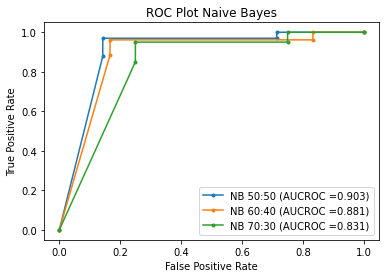

In [ ]:
#plot ROC curve dengan matplotlib.pyplot
y_dec_1 = gnb.fit(x_train_1, y_train_1).predict_proba(x_test_1)[:, 1]
y_dec_2 = gnb.fit(x_train_2, y_train_2).predict_proba(x_test_2)[:, 1]
y_dec_3 = gnb.fit(x_train_3, y_train_3).predict_proba(x_test_3)[:, 1]

fpr_1, tpr_1, thresholds_1 = metrics.roc_curve(y_test_1, y_dec_1, pos_label='live')
fpr_2, tpr_2, thresholds_2 = metrics.roc_curve(y_test_2, y_dec_2, pos_label='live')
fpr_3, tpr_3, thresholds_3 = metrics.roc_curve(y_test_3, y_dec_3, pos_label='live')

plt.plot(fpr_1, tpr_1, marker='.', label="NB 50:50 (AUCROC ={:.3f})".format(auc(fpr_1, tpr_1)))
plt.plot(fpr_2, tpr_2, marker='.', label="NB 60:40 (AUCROC ={:.3f})".format(auc(fpr_2, tpr_2)))
plt.plot(fpr_3, tpr_3, marker='.', label="NB 70:30 (AUCROC ={:.3f})".format(auc(fpr_3, tpr_3)))

plt.title('ROC Plot Naive Bayes')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## Tunning Hyperparameter NB

In [ ]:
param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

In [ ]:
nb_grid = GridSearchCV(estimator=GaussianNB(), 
                       param_grid=param_grid_nb, 
                       verbose=1, 
                       cv=10, 
                       n_jobs=-1)

nb_grid.fit(x_train_1, y_train_1)
nb_grid.fit(x_train_2, y_train_2)
nb_grid.fit(x_train_3, y_train_3)

print( )
print(nb_grid.best_estimator_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits

GaussianNB(var_smoothing=0.0001232846739442066)


In [ ]:
y_pred_cv1 = nb_grid.predict(x_test_1)
y_pred_cv2 = nb_grid.predict(x_test_2)
y_pred_cv3 = nb_grid.predict(x_test_3)

In [ ]:
print("Nilai akurasi komposisi 50:50 adalah {:.2f}%".format(metrics.accuracy_score(y_test_1, y_pred_cv1)*100))
print("Nilai akurasi komposisi 60:40 adalah {:.2f}%".format(metrics.accuracy_score(y_test_2, y_pred_cv2)*100))
print("Nilai akurasi komposisi 70:30 adalah {:.2f}%".format(metrics.accuracy_score(y_test_3, y_pred_cv3)*100))

Nilai akurasi komposisi 50:50 adalah 90.00%
Nilai akurasi komposisi 60:40 adalah 87.50%
Nilai akurasi komposisi 70:30 adalah 83.33%


##Seleksi Fitur NB

#### Simple feature selection

In [ ]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split 
from sklearn import metrics 
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB

# np.random.seed(123) 
df = pd.read_excel('hepatitis_drop.xlsx') 
df = df.iloc[:,1:-1] #remove kolom id 
label_encoder = LabelEncoder() 
df.iloc[:,0] = label_encoder.fit_transform(df.iloc[:,0]).astype('float64') #mengubah value diagnosis menjadi 1 dan 0 

paramater = df.iloc[:,1:-1] 
target = df.iloc[:,0] 

#menghitung correlation 
corr_matrix = paramater.corr().abs() 

#ambil matrix segitiga atas 
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)) 

#temukan feature dengan correlation diatas 0.9 
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)] 
for ls in to_drop: 
  paramater=paramater.drop([ls],axis=1) 
  
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(paramater.values, target.values, test_size = 0.5, random_state=18)
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(paramater.values, target.values, test_size = 0.6, random_state=18)
x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(paramater.values, target.values, test_size = 0.7, random_state=18)

gnb = GaussianNB() # The default kernel adalah gaussian kernel
gnb.fit(x_train_1, y_train_1)
gnb.fit(x_train_2, y_train_2)
gnb.fit(x_train_3, y_train_3)

y_pred_1 = gnb.predict(x_test_1)
y_pred_2 = gnb.predict(x_test_2)
y_pred_3 = gnb.predict(x_test_3)

print("Akurasi 50:50 = ",metrics.accuracy_score(y_test_1, y_pred_1))
print("Akurasi 60:40 = ",metrics.accuracy_score(y_test_2, y_pred_2))
print("Akurasi 70:30 = ",metrics.accuracy_score(y_test_3, y_pred_3))

Akurasi 50:50 =  0.45
Akurasi 60:40 =  0.4583333333333333
Akurasi 70:30 =  0.4642857142857143


#### Boruta feature selection

In [ ]:
!pip install BorutaShap

  0%|          | 0/100 [00:00<?, ?it/s]

6 attributes confirmed important: ['histology', 'varices', 'protime', 'malaise', 'bilirubin', 'albumin']
12 attributes confirmed unimportant: ['steroid', 'age', 'fatigue', 'ascites', 'sex', 'anorexia', 'antivirals', 'liver_big', 'sgot', 'liver_firm', 'spleen_palpable', 'alk_phosphate']
1 tentative attributes remains: ['spiders']


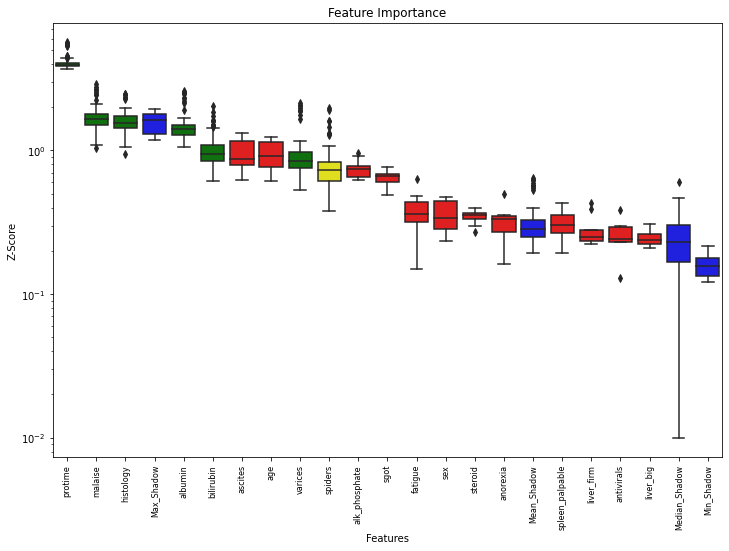

In [ ]:
from BorutaShap import BorutaShap, load_data
x_drop = pd.DataFrame(x_drop)
df_drop = x_drop.copy()
df_drop['class']=y
df_drop.to_excel('df_drop.xlsx', index=False)

df_drops = pd.read_excel('df_drop.xlsx')

x = df_drops.drop(['class'], axis=1)
y = df_drops['class']

model = RandomForestClassifier(random_state=75)

# if classification is False it is a Regression problem
Feature_Selector = BorutaShap(model=model,
                              importance_measure='shap',
                              classification=True)

Feature_Selector.fit(x, y, n_trials=100, sample=False,
            	     train_or_test = 'test', normalize=True,
                   verbose=True)

# Returns Boxplot of features
Feature_Selector.plot(which_features='all')

In [ ]:
# Returns a subset of the original data with the selected features
subset = Feature_Selector.Subset()
subset

,histology,varices,protime,malaise,bilirubin,albumin
0,0,0,75,0,0.9,4.0
1,0,0,85,0,1.3,4.4
2,0,0,54,0,1.0,3.7
3,0,0,52,0,0.9,3.9
4,0,0,78,0,2.2,4.9
...,...,...,...,...,...,...
75,1,0,85,0,1.3,4.2
76,1,0,35,1,1.4,3.5
77,1,0,54,0,1.2,4.2
78,1,1,48,0,1.5,4.1


In [ ]:
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(x, y, test_size = 0.5, random_state=18)
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(x, y, test_size = 0.6, random_state=18)
x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(x, y, test_size = 0.7, random_state=18)

gnb = GaussianNB() # The default kernel adalah gaussian kernel
gnb.fit(x_train_1, y_train_1)
gnb.fit(x_train_2, y_train_2)
gnb.fit(x_train_3, y_train_3)

y_pred_1 = gnb.predict(x_test_1)
y_pred_2 = gnb.predict(x_test_2)
y_pred_3 = gnb.predict(x_test_3)

print("Akurasi 50:50 = ",metrics.accuracy_score(y_test_1, y_pred_1))
print("Akurasi 60:40 = ",metrics.accuracy_score(y_test_2, y_pred_2))
print("Akurasi 70:30 = ",metrics.accuracy_score(y_test_3, y_pred_3))

Akurasi 50:50 =  0.925
Akurasi 60:40 =  0.9375
Akurasi 70:30 =  0.9464285714285714


##Preprocessing NB + MF

###one hot

In [ ]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
import sklearn.neighbors._base
import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

from sklearn.model_selection import train_test_split

# Membaca dataset
hepatitis = pd.read_csv('/content/drive/MyDrive/dataset/hepatitis_pre.csv', delimiter = ",")
hepatitis.drop(hepatitis.columns[0], axis=1, inplace=True)
# df=hepatitis.replace('?',np.nan)

# Variabel independen
x = hepatitis.drop (["class"], axis = 1)

# Variabel dependen
y = hepatitis ["class"]

# Imputasi missforest
cat_column = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14',
              '15','16','17','18','19','20','21','22','23','24','25','26','27',
              '28','29','31','32','33','34','35']
cat_cols = []
for i in cat_column :
    cat_cols.append(x.columns.to_list().index(i))
imputer = MissForest(random_state=42)
x_imputed = imputer.fit_transform(x, cat_vars=cat_cols)

# Save imputed data to csv
df_imputed = pd.DataFrame(x_imputed,columns=x.columns)
df_imputed['class'] = y
df_imputed.to_csv('/content/drive/MyDrive/dataset/hepatitis_imputed_missforest.csv')

# Import train_test_split function
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(df_imputed.drop (["class"], axis = 1), y, test_size = 0.5, random_state = 42)
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(df_imputed.drop (["class"], axis = 1), y, test_size = 0.4, random_state = 42)
x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(df_imputed.drop (["class"], axis = 1), y, test_size = 0.3, random_state = 42)
x_train_4, x_test_4, y_train_4, y_test_4 = train_test_split(df_imputed.drop (["class"], axis = 1), y, test_size = 0.2, random_state = 42)
x_train_5, x_test_5, y_train_5, y_test_5 = train_test_split(df_imputed.drop (["class"], axis = 1), y, test_size = 0.1, random_state = 42)

# Mengaktifkan/memanggil/membuat fungsi klasifikasi Naive bayes
modelnb = GaussianNB()

y_pred_1 = modelnb.fit(x_train_1, y_train_1).predict(x_test_1)
y_pred_2 = modelnb.fit(x_train_2, y_train_2).predict(x_test_2)
y_pred_3 = modelnb.fit(x_train_3, y_train_3).predict(x_test_3)
y_pred_4 = modelnb.fit(x_train_4, y_train_4).predict(x_test_4)
y_pred_5 = modelnb.fit(x_train_5, y_train_5).predict(x_test_5)

# Menampilkan nilai akurasi dari klasifikasi naive bayes
print( )
print("Nilai akurasi komposisi 50:50 adalah {:.2f}%".format(metrics.accuracy_score(y_test_1, y_pred_1) * 100))
print("Nilai akurasi komposisi 60:40 adalah {:.2f}%".format(metrics.accuracy_score(y_test_2, y_pred_2) * 100))
print("Nilai akurasi komposisi 70:30 adalah {:.2f}%".format(metrics.accuracy_score(y_test_3, y_pred_3) * 100))
print("Nilai akurasi komposisi 80:20 adalah {:.2f}%".format(metrics.accuracy_score(y_test_4, y_pred_4) * 100))
print("Nilai akurasi komposisi 90:10 adalah {:.2f}%".format(metrics.accuracy_score(y_test_5, y_pred_5) * 100))

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4

Nilai akurasi komposisi 50:50 adalah 61.54%
Nilai akurasi komposisi 60:40 adalah 53.23%
Nilai akurasi komposisi 70:30 adalah 40.43%
Nilai akurasi komposisi 80:20 adalah 35.48%
Nilai akurasi komposisi 90:10 adalah 25.00%


###label

In [ ]:
# Membaca dataset
hepatitis = pd.read_csv('hepatitis_pre.csv', delimiter = ",")
hepatitis.drop(hepatitis.columns[0], axis=1, inplace=True)

# Variabel independen
x = hepatitis.drop (['class'], axis = 1)

# Variabel dependen
y = hepatitis ['class']

# Imputasi missforest
cat_column = ['sex','steroid','antivirals','fatigue','malaise','anorexia',
              'liver_big','liver_firm','spleen_palpable','spiders','ascites',
              'varices','histology']
cat_cols = []
for i in cat_column :
    cat_cols.append(x.columns.to_list().index(i))
imputer = MissForest(max_iter=10,
                     n_estimators=100,
                     class_weight='balanced',
                     random_state=75)
x_imputed = imputer.fit_transform(x, cat_vars=cat_cols)

# Save imputed data to csv
df_imputed = pd.DataFrame(x_imputed,columns=x.columns)
df_imputed['class'] = y
df_imputed.to_csv('hepatitis_imputed_missforest.csv')

# Import train_test_split function
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(df_imputed.drop (["class"], axis = 1), y, test_size = 0.5, random_state = 42)
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(df_imputed.drop (["class"], axis = 1), y, test_size = 0.4, random_state = 42)
x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(df_imputed.drop (["class"], axis = 1), y, test_size = 0.3, random_state = 42)
x_train_4, x_test_4, y_train_4, y_test_4 = train_test_split(df_imputed.drop (["class"], axis = 1), y, test_size = 0.2, random_state = 42)
x_train_5, x_test_5, y_train_5, y_test_5 = train_test_split(df_imputed.drop (["class"], axis = 1), y, test_size = 0.1, random_state = 42)

# Mengaktifkan/memanggil/membuat fungsi klasifikasi Naive bayes
modelnb = GaussianNB()

y_pred_1 = modelnb.fit(x_train_1, y_train_1).predict(x_test_1)
y_pred_2 = modelnb.fit(x_train_2, y_train_2).predict(x_test_2)
y_pred_3 = modelnb.fit(x_train_3, y_train_3).predict(x_test_3)
y_pred_4 = modelnb.fit(x_train_4, y_train_4).predict(x_test_4)
y_pred_5 = modelnb.fit(x_train_5, y_train_5).predict(x_test_5)

# Menampilkan nilai akurasi dari klasifikasi naive bayes
print( )
print("Nilai akurasi komposisi 50:50 adalah {:.2f}%".format(metrics.accuracy_score(y_test_1, y_pred_1) * 100))
print("Nilai akurasi komposisi 60:40 adalah {:.2f}%".format(metrics.accuracy_score(y_test_2, y_pred_2) * 100))
print("Nilai akurasi komposisi 70:30 adalah {:.2f}%".format(metrics.accuracy_score(y_test_3, y_pred_3) * 100))
print("Nilai akurasi komposisi 80:20 adalah {:.2f}%".format(metrics.accuracy_score(y_test_4, y_pred_4) * 100))
print("Nilai akurasi komposisi 90:10 adalah {:.2f}%".format(metrics.accuracy_score(y_test_5, y_pred_5) * 100))

Iteration: 0
Iteration: 1
Iteration: 2

Nilai akurasi komposisi 50:50 adalah 83.33%
Nilai akurasi komposisi 60:40 adalah 85.48%
Nilai akurasi komposisi 70:30 adalah 82.98%
Nilai akurasi komposisi 80:20 adalah 80.65%
Nilai akurasi komposisi 90:10 adalah 87.50%


###ordinal + stratify

In [ ]:
# Membaca dataset
hepatitis = pd.read_csv('hepatitis_pre.csv', delimiter = ",")
hepatitis.drop(hepatitis.columns[0], axis=1, inplace=True)

# Variabel independen
x = hepatitis.drop (["class"], axis = 1)

# Variabel dependen
y = hepatitis ["class"]

# Imputasi missforest
cat_column = ['sex','steroid','antivirals','fatigue','malaise','anorexia',
              'liver_big','liver_firm','spleen_palpable','spiders','ascites',
              'varices','histology']
cat_cols = []
for i in cat_column :
    cat_cols.append(x.columns.to_list().index(i))
imputer = MissForest(max_iter=10,
                     n_estimators=100,
                     class_weight='balanced',
                     random_state=75)
x_imputed = imputer.fit_transform(x, cat_vars=cat_cols)

# Save imputed data to csv
df_imputed = pd.DataFrame(x_imputed,columns=x.columns)
df_imputed['class'] = y
df_imputed.to_csv('hepatitis_imputed_missforest.csv')

# Import train_test_split function
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(df_imputed.drop (["class"], axis = 1), y, test_size = 0.5, stratify=y, random_state = 75)
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(df_imputed.drop (["class"], axis = 1), y, test_size = 0.4, stratify=y, random_state = 75)
x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(df_imputed.drop (["class"], axis = 1), y, test_size = 0.3, stratify=y, random_state = 75)
# x_train_4, x_test_4, y_train_4, y_test_4 = train_test_split(df_imputed.drop (["class"], axis = 1), y, test_size = 0.2, stratify=y, random_state = 75)
# x_train_5, x_test_5, y_train_5, y_test_5 = train_test_split(df_imputed.drop (["class"], axis = 1), y, test_size = 0.1, stratify=y, random_state = 75)

# Mengaktifkan/memanggil/membuat fungsi klasifikasi Naive bayes
modelnb = GaussianNB()

y_pred_1 = modelnb.fit(x_train_1, y_train_1).predict(x_test_1)
y_pred_2 = modelnb.fit(x_train_2, y_train_2).predict(x_test_2)
y_pred_3 = modelnb.fit(x_train_3, y_train_3).predict(x_test_3)
# y_pred_4 = modelnb.fit(x_train_4, y_train_4).predict(x_test_4)
# y_pred_5 = modelnb.fit(x_train_5, y_train_5).predict(x_test_5)

# Menampilkan nilai akurasi dari klasifikasi naive bayes
print( )
print("Nilai akurasi komposisi 50:50 adalah {:.2f}%".format(metrics.accuracy_score(y_test_1, y_pred_1) * 100))
print("Nilai akurasi komposisi 60:40 adalah {:.2f}%".format(metrics.accuracy_score(y_test_2, y_pred_2) * 100))
print("Nilai akurasi komposisi 70:30 adalah {:.2f}%".format(metrics.accuracy_score(y_test_3, y_pred_3) * 100))
# print("Nilai akurasi komposisi 80:20 adalah {:.2f}%".format(metrics.accuracy_score(y_test_4, y_pred_4) * 100))
# print("Nilai akurasi komposisi 90:10 adalah {:.2f}%".format(metrics.accuracy_score(y_test_5, y_pred_5) * 100))

Iteration: 0
Iteration: 1
Iteration: 2

Nilai akurasi komposisi 50:50 adalah 80.77%
Nilai akurasi komposisi 60:40 adalah 82.26%
Nilai akurasi komposisi 70:30 adalah 85.11%


###one hot + stratify

In [ ]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
import sklearn.neighbors._base
import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

from sklearn.model_selection import train_test_split

# Membaca dataset
hepatitis = pd.read_csv('/content/drive/MyDrive/dataset/hepatitis_pre.csv', delimiter = ",")
hepatitis.drop(hepatitis.columns[0], axis=1, inplace=True)
# df=hepatitis.replace('?',np.nan)

# Variabel independen
x = hepatitis.drop (["class"], axis = 1)

# Variabel dependen
y = hepatitis ["class"]

# for col in ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14',
#             '15','16','17','18','19','20','21','22','23','24','25','26','27',
#             '28','29','31','32','33','34','35']:
# for col in ['sex','steroid','antivirals','fatigue','malaise','anorexia',
#               'liver_big','liver_firm','spleen_palpable','spiders','ascites',
#               'varices','histology']:
#               df[col] = df[col].astype('category')
# cat_cols = [df.columns.get_loc(col) for col in
# df.select_dtypes(['category']).columns.tolist()]
# x,y=df.iloc[:,:-1],df.iloc[:,[-1]]

# Imputasi missforest
cat_column = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14',
              '15','16','17','18','19','20','21','22','23','24','25','26','27',
              '28','29','31','32','33','34','35']
cat_cols = []
for i in cat_column :
    cat_cols.append(x.columns.to_list().index(i))
imputer = MissForest(random_state=42)
x_imputed = imputer.fit_transform(x, cat_vars=cat_cols)

# Save imputed data to csv
df_imputed = pd.DataFrame(x_imputed,columns=x.columns)
df_imputed['class'] = y
df_imputed.to_csv('/content/drive/MyDrive/dataset/hepatitis_imputed_missforest.csv')

# Import train_test_split function
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(df_imputed.drop (["class"], axis = 1), y, test_size = 0.5, stratify=y, random_state = 42)
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(df_imputed.drop (["class"], axis = 1), y, test_size = 0.4, stratify=y, random_state = 42)
x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(df_imputed.drop (["class"], axis = 1), y, test_size = 0.3, stratify=y, random_state = 42)
x_train_4, x_test_4, y_train_4, y_test_4 = train_test_split(df_imputed.drop (["class"], axis = 1), y, test_size = 0.2, stratify=y, random_state = 42)
x_train_5, x_test_5, y_train_5, y_test_5 = train_test_split(df_imputed.drop (["class"], axis = 1), y, test_size = 0.1, stratify=y, random_state = 42)

# Mengaktifkan/memanggil/membuat fungsi klasifikasi Naive bayes
modelnb = GaussianNB()

y_pred_1 = modelnb.fit(x_train_1, y_train_1).predict(x_test_1)
y_pred_2 = modelnb.fit(x_train_2, y_train_2).predict(x_test_2)
y_pred_3 = modelnb.fit(x_train_3, y_train_3).predict(x_test_3)
y_pred_4 = modelnb.fit(x_train_4, y_train_4).predict(x_test_4)
y_pred_5 = modelnb.fit(x_train_5, y_train_5).predict(x_test_5)

# Menampilkan nilai akurasi dari klasifikasi naive bayes
print( )
print("Nilai akurasi komposisi 50:50 adalah {:.2f}%".format(metrics.accuracy_score(y_test_1, y_pred_1) * 100))
print("Nilai akurasi komposisi 60:40 adalah {:.2f}%".format(metrics.accuracy_score(y_test_2, y_pred_2) * 100))
print("Nilai akurasi komposisi 70:30 adalah {:.2f}%".format(metrics.accuracy_score(y_test_3, y_pred_3) * 100))
print("Nilai akurasi komposisi 80:20 adalah {:.2f}%".format(metrics.accuracy_score(y_test_4, y_pred_4) * 100))
print("Nilai akurasi komposisi 90:10 adalah {:.2f}%".format(metrics.accuracy_score(y_test_5, y_pred_5) * 100))

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4

Nilai akurasi komposisi 50:50 adalah 76.92%
Nilai akurasi komposisi 60:40 adalah 74.19%
Nilai akurasi komposisi 70:30 adalah 76.60%
Nilai akurasi komposisi 80:20 adalah 51.61%
Nilai akurasi komposisi 90:10 adalah 43.75%


###label + stratify

In [ ]:
# Membaca dataset
hepatitis = pd.read_csv('hepatitis_pre.csv', delimiter = ",")
hepatitis.drop(hepatitis.columns[0], axis=1, inplace=True)

# Variabel independen
x = hepatitis.drop (["class"], axis = 1)

# Variabel dependen
y = hepatitis ["class"]

# Imputasi missforest
cat_column = ['sex','steroid','antivirals','fatigue','malaise','anorexia',
              'liver_big','liver_firm','spleen_palpable','spiders','ascites',
              'varices','histology']
cat_cols = []
for i in cat_column :
    cat_cols.append(x.columns.to_list().index(i))
imputer = MissForest(max_iter=10,
                     n_estimators=100,
                     class_weight='balanced',
                     random_state=75)
x_imputed = imputer.fit_transform(x, cat_vars=cat_cols)

# Save imputed data to csv
df_imputed = pd.DataFrame(x_imputed,columns=x.columns)
df_imputed['class'] = y
df_imputed.to_csv('hepatitis_imputed_missforest.csv')

# Import train_test_split function
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(df_imputed.drop (["class"], axis = 1), y, test_size = 0.5, stratify=y, random_state = 42)
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(df_imputed.drop (["class"], axis = 1), y, test_size = 0.4, stratify=y, random_state = 42)
x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(df_imputed.drop (["class"], axis = 1), y, test_size = 0.3, stratify=y, random_state = 42)
x_train_4, x_test_4, y_train_4, y_test_4 = train_test_split(df_imputed.drop (["class"], axis = 1), y, test_size = 0.2, stratify=y, random_state = 42)
x_train_5, x_test_5, y_train_5, y_test_5 = train_test_split(df_imputed.drop (["class"], axis = 1), y, test_size = 0.1, stratify=y, random_state = 42)

# Mengaktifkan/memanggil/membuat fungsi klasifikasi Naive bayes
modelnb = GaussianNB()

y_pred_1 = modelnb.fit(x_train_1, y_train_1).predict(x_test_1)
y_pred_2 = modelnb.fit(x_train_2, y_train_2).predict(x_test_2)
y_pred_3 = modelnb.fit(x_train_3, y_train_3).predict(x_test_3)
y_pred_4 = modelnb.fit(x_train_4, y_train_4).predict(x_test_4)
y_pred_5 = modelnb.fit(x_train_5, y_train_5).predict(x_test_5)

# Menampilkan nilai akurasi dari klasifikasi naive bayes
print( )
print("Nilai akurasi komposisi 50:50 adalah {:.2f}%".format(metrics.accuracy_score(y_test_1, y_pred_1) * 100))
print("Nilai akurasi komposisi 60:40 adalah {:.2f}%".format(metrics.accuracy_score(y_test_2, y_pred_2) * 100))
print("Nilai akurasi komposisi 70:30 adalah {:.2f}%".format(metrics.accuracy_score(y_test_3, y_pred_3) * 100))
print("Nilai akurasi komposisi 80:20 adalah {:.2f}%".format(metrics.accuracy_score(y_test_4, y_pred_4) * 100))
print("Nilai akurasi komposisi 90:10 adalah {:.2f}%".format(metrics.accuracy_score(y_test_5, y_pred_5) * 100))

Iteration: 0
Iteration: 1
Iteration: 2

Nilai akurasi komposisi 50:50 adalah 78.21%
Nilai akurasi komposisi 60:40 adalah 75.81%
Nilai akurasi komposisi 70:30 adalah 76.60%
Nilai akurasi komposisi 80:20 adalah 77.42%
Nilai akurasi komposisi 90:10 adalah 75.00%


### Penyeimbangan data

#### Standar + SMOTE

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

x_train_scl1 = sc.fit_transform(x_train_1)
x_test_scl1  = sc.fit_transform(x_test_1)
x_train_scl2 = sc.fit_transform(x_train_2)
x_test_scl2  = sc.fit_transform(x_test_2)
x_train_scl3 = sc.fit_transform(x_train_3)
x_test_scl3  = sc.fit_transform(x_test_3)

from imblearn.over_sampling import SMOTE, ADASYN
smote = SMOTE()
x_res_1, y_res_1 = smote.fit_resample(x_train_scl1, y_train_1)
x_res_2, y_res_2 = smote.fit_resample(x_train_scl2, y_train_2)
x_res_3, y_res_3 = smote.fit_resample(x_train_scl3, y_train_3)

gnb = GaussianNB()
gnb.fit(x_res_1, y_res_1)
gnb.fit(x_res_2, y_res_2)
gnb.fit(x_res_3, y_res_3)

y_pred_1 = gnb.predict(x_test_1)
y_pred_2 = gnb.predict(x_test_2)
y_pred_3 = gnb.predict(x_test_3)

print("Nilai akurasi komposisi 50:50 adalah {:.2f}%".format(metrics.accuracy_score(y_test_1, y_pred_1) * 100))
print("Nilai akurasi komposisi 60:40 adalah {:.2f}%".format(metrics.accuracy_score(y_test_2, y_pred_2) * 100))
print("Nilai akurasi komposisi 70:30 adalah {:.2f}%".format(metrics.accuracy_score(y_test_3, y_pred_3) * 100))

Nilai akurasi komposisi 50:50 adalah 79.49%
Nilai akurasi komposisi 60:40 adalah 79.03%
Nilai akurasi komposisi 70:30 adalah 76.60%


#### MinMax + SMOTE

In [ ]:
# normalisasi data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaler.fit(x_train_1)
scaler.fit(x_train_2)
scaler.fit(x_train_3)

x_train_scl1= scaler.transform(x_train_1)
x_test_scl2= scaler.transform(x_test_1)

x_train_scl2= scaler.transform(x_train_2)
x_test_scl2= scaler.transform(x_test_2)

x_train_scl3= scaler.transform(x_train_3)
x_test_scl3= scaler.transform(x_test_3)

#Penyeimbangan Data
from imblearn.over_sampling import SMOTE, ADASYN

smote = SMOTE()
x_res_1, y_res_1 = smote.fit_resample(x_train_scl1, y_train_1)
x_res_2, y_res_2 = smote.fit_resample(x_train_scl2, y_train_2)
x_res_3, y_res_3 = smote.fit_resample(x_train_scl3, y_train_3)

# ada = ADASYN()
# x_res_1, y_res_1 = ada.fit_resample(x_train_scl1, y_train_1)
# x_res_2, y_res_2 = ada.fit_resample(x_train_scl2, y_train_2)
# x_res_3, y_res_3 = ada.fit_resample(x_train_scl3, y_train_3)

# Memasukkan data training pada fungsi klasifikasi naive bayes
y_pred_1 = gnb.fit(x_res_1, y_res_1).predict(x_test_1)
y_pred_2 = gnb.fit(x_res_2, y_res_2).predict(x_test_2)
y_pred_3 = gnb.fit(x_res_3, y_res_3).predict(x_test_3)

# Menghitung nilai akurasi dari klasifikasi naive bayes 
print( )
print("Nilai akurasi komposisi 50:50 adalah {:.2f}%".format(metrics.accuracy_score(y_test_1, y_pred_1) * 100))
print("Nilai akurasi komposisi 60:40 adalah {:.2f}%".format(metrics.accuracy_score(y_test_2, y_pred_2) * 100))
print("Nilai akurasi komposisi 70:30 adalah {:.2f}%".format(metrics.accuracy_score(y_test_3, y_pred_3) * 100))


Nilai akurasi komposisi 50:50 adalah 79.49%
Nilai akurasi komposisi 60:40 adalah 79.03%
Nilai akurasi komposisi 70:30 adalah 76.60%


###Cek data oversampling

In [ ]:
print("data train_1 : ", Counter(y_train_1))
print("data test_1  : ", Counter(y_test_1))
print("DATA TOTAL 1 : ", Counter(y_train_1)+Counter(y_test_1), '\n')

print("data train_2 : ", Counter(y_train_2))
print("data test_2  : ", Counter(y_test_2))
print("DATA TOTAL 2 : ", Counter(y_train_2)+Counter(y_test_2), '\n')

print("data train_3 : ", Counter(y_train_3))
print("data test_3  : ", Counter(y_test_3))
print("DATA TOTAL 3 : ", Counter(y_train_3)+Counter(y_test_3))

data train_1 :  Counter({'live': 61, 'die': 16})
data test_1  :  Counter({'live': 62, 'die': 16})
DATA TOTAL 1 :  Counter({'live': 123, 'die': 32}) 

data train_2 :  Counter({'live': 74, 'die': 19})
data test_2  :  Counter({'live': 49, 'die': 13})
DATA TOTAL 2 :  Counter({'live': 123, 'die': 32}) 

data train_3 :  Counter({'live': 87, 'die': 21})
data test_3  :  Counter({'live': 36, 'die': 11})
DATA TOTAL 3 :  Counter({'live': 123, 'die': 32})


In [ ]:
print("Sebelum oversampling, label live : {}".format(sum(y_train_3=='live')))
print("Sebelum oversampling, label die : {}\n".format(sum(y_train_3=='die')))

print("sesudah oversampling, label live : {}".format(sum(y_res_1=='live')))
print("sesudah oversampling, label die : {}\n".format(sum(y_res_1=='die')))

Sebelum oversampling, label live : 87
Sebelum oversampling, label die : 21

sesudah oversampling, label live : 61
sesudah oversampling, label die : 61



###Data latih

####latih 1 50:50

In [ ]:
print("label live : {}".format(sum(y_train_1=='live')))
print("label die  : {}\n".format(sum(y_train_1=='die')))

train1 = x_train_1
train1

label live : 61
label die  : 16



,sex,steroid,antivirals,fatigue,malaise,anorexia,liver_big,liver_firm,spleen_palpable,spiders,ascites,varices,histology,age,bilirubin,alk_phosphate,sgot,albumin,protime
5,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,34.0,0.9,95.00,28.0,4.0,75.00
97,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,44.0,3.0,114.00,65.0,3.5,39.76
110,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,7.0,0.7,256.00,25.0,4.2,82.20
41,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,4.6,56.00,16.0,4.6,61.35
21,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,27.0,1.2,133.00,98.0,4.1,39.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0,0.9,58.00,92.0,4.3,73.00
26,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,49.0,0.6,85.00,48.0,3.7,52.75
136,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,51.0,0.8,83.57,33.0,4.5,59.75
19,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,38.0,0.7,70.00,28.0,4.2,62.00


####latih 2 60:40

In [ ]:
print("label live : {}".format(sum(y_train_2=='live')))
print("label die  : {}\n".format(sum(y_train_2=='die')))

train2 = x_train_2
train2

label live : 74
label die  : 19



,sex,steroid,antivirals,fatigue,malaise,anorexia,liver_big,liver_firm,spleen_palpable,spiders,ascites,varices,histology,age,bilirubin,alk_phosphate,sgot,albumin,protime
140,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,36.0,1.7,295.00,60.0,2.7,33.35
92,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,33.0,1.0,81.11,60.0,4.0,70.53
39,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,65.0,0.3,180.00,53.0,2.9,74.00
89,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,38.0,0.6,76.00,18.0,4.4,84.00
15,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,38.0,2.0,72.00,89.0,2.9,46.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0,0.9,58.00,92.0,4.3,73.00
26,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,49.0,0.6,85.00,48.0,3.7,52.75
136,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,51.0,0.8,83.57,33.0,4.5,59.75
19,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,38.0,0.7,70.00,28.0,4.2,62.00


####latih 3 70:30

In [ ]:
print("label live : {}".format(sum(y_train_3=='live')))
print("label die  : {}\n".format(sum(y_train_3=='die')))

train3 = x_train_3
train3

label live : 87
label die  : 21



,sex,steroid,antivirals,fatigue,malaise,anorexia,liver_big,liver_firm,spleen_palpable,spiders,ascites,varices,histology,age,bilirubin,alk_phosphate,sgot,albumin,protime
51,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,39.0,1.000,85.00,20.0,4.000,89.29
99,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,60.0,1.636,132.75,40.0,3.264,49.93
66,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0,0.700,62.00,33.0,3.000,52.52
84,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,62.0,1.300,141.00,156.0,3.900,58.00
7,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,1.000,83.51,45.9,4.402,73.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0,0.900,58.00,92.0,4.300,73.00
26,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,49.0,0.600,85.00,48.0,3.700,52.75
136,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,51.0,0.800,83.57,33.0,4.500,59.75
19,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,38.0,0.700,70.00,28.0,4.200,62.00


### Data tes

#### tes 1 50:50

In [ ]:
print("label live : {}".format(sum(y_test_1=='live')))
print("label die  : {}\n".format(sum(y_test_1=='die')))

tes1 = x_test_1
tes1

label live : 62
label die  : 16



,sex,steroid,antivirals,fatigue,malaise,anorexia,liver_big,liver_firm,spleen_palpable,spiders,ascites,varices,histology,age,bilirubin,alk_phosphate,sgot,albumin,protime
133,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,72.0,1.0,115.0,52.0,3.4,50.00
50,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,39.0,0.9,85.0,60.0,4.0,68.82
95,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,40.0,0.6,40.0,69.0,4.2,67.00
128,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,54.0,1.2,85.0,92.0,3.1,66.00
125,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,34.0,0.7,70.0,24.0,4.1,100.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,36.0,1.1,141.0,75.0,3.3,47.32
82,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.7,100.0,31.0,4.0,100.00
100,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,48.0,4.8,123.0,157.0,2.7,31.00
121,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,20.0,1.0,160.0,118.0,2.9,23.00


#### tes 2 60:40


In [ ]:
print("label live : {}".format(sum(y_test_2=='live')))
print("label die  : {}\n".format(sum(y_test_2=='die')))

tes2 = x_test_2
tes2

label live : 49
label die  : 13



,sex,steroid,antivirals,fatigue,malaise,anorexia,liver_big,liver_firm,spleen_palpable,spiders,ascites,varices,histology,age,bilirubin,alk_phosphate,sgot,albumin,protime
133,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,72.0,1.0,115.0,52.0,3.4,50.00
50,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,39.0,0.9,85.0,60.0,4.0,68.82
95,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,40.0,0.6,40.0,69.0,4.2,67.00
128,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,54.0,1.2,85.0,92.0,3.1,66.00
125,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,34.0,0.7,70.0,24.0,4.1,100.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,38.0,1.2,118.0,16.0,2.8,41.84
117,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1.0,139.0,81.0,3.9,62.00
53,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,40.0,1.2,85.0,31.0,4.0,100.00
30,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,39.0,2.3,280.0,98.0,3.8,40.00


#### tes 3 70:30


In [ ]:
print("label live : {}".format(sum(y_test_3=='live')))
print("label die  : {}\n".format(sum(y_test_3=='die')))

tes3 = x_test_3
tes3

label live : 36
label die  : 11



,sex,steroid,antivirals,fatigue,malaise,anorexia,liver_big,liver_firm,spleen_palpable,spiders,ascites,varices,histology,age,bilirubin,alk_phosphate,sgot,albumin,protime
133,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,72.0,1.000,115.00,52.00,3.400,50.00
50,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,39.0,0.900,85.00,60.00,4.000,68.82
95,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,40.0,0.600,40.00,69.00,4.200,67.00
128,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,54.0,1.200,85.00,92.00,3.100,66.00
125,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,34.0,0.700,70.00,24.00,4.100,100.00
86,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,44.0,0.900,135.00,55.00,3.185,41.00
6,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,51.0,1.707,116.70,73.89,3.333,43.30
72,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,51.0,0.900,76.00,271.00,4.400,58.89
29,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,51.0,1.000,78.00,58.00,4.600,52.00
129,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,57.0,4.600,82.00,55.00,3.300,30.00


## **Score AUC ROC NB+MF**

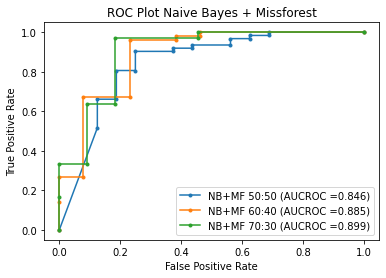

In [ ]:
#plot ROC curve dengan matplotlib.pyplot
y_dec_1 = gnb.fit(x_train_1, y_train_1).predict_proba(x_test_1)[:, 1]
y_dec_2 = gnb.fit(x_train_2, y_train_2).predict_proba(x_test_2)[:, 1]
y_dec_3 = gnb.fit(x_train_3, y_train_3).predict_proba(x_test_3)[:, 1]

fpr_1, tpr_1, thresholds_1 = metrics.roc_curve(y_test_1, y_dec_1, pos_label='live')
fpr_2, tpr_2, thresholds_2 = metrics.roc_curve(y_test_2, y_dec_2, pos_label='live')
fpr_3, tpr_3, thresholds_3 = metrics.roc_curve(y_test_3, y_dec_3, pos_label='live')

plt.plot(fpr_1, tpr_1, marker='.', label="NB+MF 50:50 (AUCROC ={:.3f})".format(auc(fpr_1, tpr_1)))
plt.plot(fpr_2, tpr_2, marker='.', label="NB+MF 60:40 (AUCROC ={:.3f})".format(auc(fpr_2, tpr_2)))
plt.plot(fpr_3, tpr_3, marker='.', label="NB+MF 70:30 (AUCROC ={:.3f})".format(auc(fpr_3, tpr_3)))

plt.title('ROC Plot Naive Bayes + Missforest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## Tunning Hyperparameter NB+MF

In [ ]:
param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

In [ ]:
gnb_grid = GridSearchCV(estimator=GaussianNB(), 
                       param_grid=param_grid_nb, 
                       verbose=1, 
                       cv=10, 
                       n_jobs=-1)

gnb_grid.fit(x_train_1, y_train_1)
gnb_grid.fit(x_train_2, y_train_2)
gnb_grid.fit(x_train_3, y_train_3)

print( )
print(gnb_grid.best_estimator_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits

GaussianNB(var_smoothing=5.336699231206313e-06)


In [ ]:
y_pred_cv1 = gnb_grid.predict(x_test_1)
y_pred_cv2 = gnb_grid.predict(x_test_2)
y_pred_cv3 = gnb_grid.predict(x_test_3)

In [ ]:
print("Nilai akurasi komposisi 50:50 adalah {:.2f}%".format(metrics.accuracy_score(y_test_1, y_pred_cv1)*100))
print("Nilai akurasi komposisi 60:40 adalah {:.2f}%".format(metrics.accuracy_score(y_test_2, y_pred_cv2)*100))
print("Nilai akurasi komposisi 70:30 adalah {:.2f}%".format(metrics.accuracy_score(y_test_3, y_pred_cv3)*100))

Nilai akurasi komposisi 50:50 adalah 85.90%
Nilai akurasi komposisi 60:40 adalah 90.32%
Nilai akurasi komposisi 70:30 adalah 89.36%


##Seleksi Fitur NB+MF

#### Simple feature selection

In [ ]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split 
from sklearn import metrics 
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB

# np.random.seed(123) 
df = pd.read_excel('hepatitis_missforest.xlsx') 
df = df.iloc[:,1:-1] #remove kolom id 
label_encoder = LabelEncoder() 
df.iloc[:,0] = label_encoder.fit_transform(df.iloc[:,0]).astype('float64') #mengubah value diagnosis menjadi 1 dan 0 

paramater = df.iloc[:,1:-1] 
target = df.iloc[:,0] 

#menghitung correlation 
corr_matrix = paramater.corr().abs() 

#ambil matrix segitiga atas 
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)) 

#temukan feature dengan correlation diatas 0.9 
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)] 
for ls in to_drop: 
  paramater=paramater.drop([ls],axis=1) 
  
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(paramater.values, target.values, test_size = 0.5, random_state=18)
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(paramater.values, target.values, test_size = 0.6, random_state=18)
x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(paramater.values, target.values, test_size = 0.7, random_state=18)

gnb = GaussianNB() # The default kernel adalah gaussian kernel
gnb.fit(x_train_1, y_train_1)
gnb.fit(x_train_2, y_train_2)
gnb.fit(x_train_3, y_train_3)

y_pred_1 = gnb.predict(x_test_1)
y_pred_2 = gnb.predict(x_test_2)
y_pred_3 = gnb.predict(x_test_3)

print("Akurasi 50:50 = ",metrics.accuracy_score(y_test_1, y_pred_1))
print("Akurasi 60:40 = ",metrics.accuracy_score(y_test_2, y_pred_2))
print("Akurasi 70:30 = ",metrics.accuracy_score(y_test_3, y_pred_3))

Akurasi 50:50 =  0.5128205128205128
Akurasi 60:40 =  0.5053763440860215
Akurasi 70:30 =  0.46788990825688076


#### Boruta feature selection

  0%|          | 0/100 [00:00<?, ?it/s]

6 attributes confirmed important: ['age', 'ascites', 'spiders', 'protime', 'bilirubin', 'albumin']
13 attributes confirmed unimportant: ['steroid', 'histology', 'fatigue', 'varices', 'sex', 'anorexia', 'antivirals', 'liver_big', 'sgot', 'malaise', 'liver_firm', 'spleen_palpable', 'alk_phosphate']
0 tentative attributes remains: []


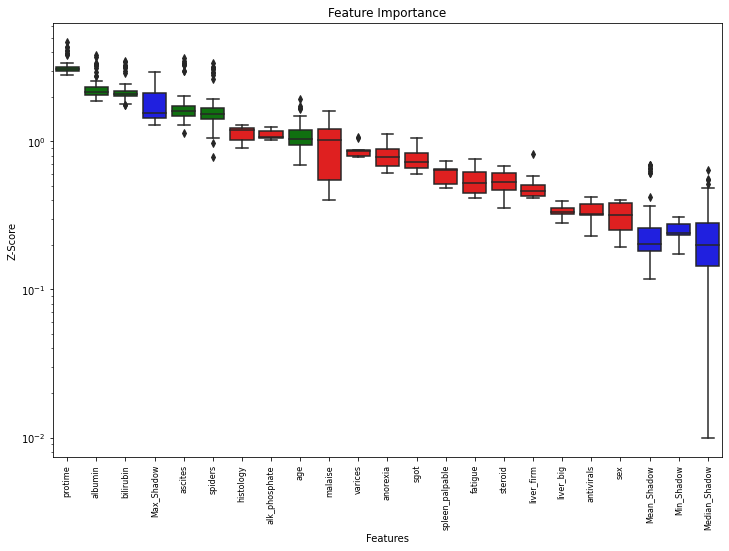

In [ ]:
from BorutaShap import BorutaShap, load_data
df_imp = df_imputed
x_imp = pd.DataFrame(df_imputed)
df_imp = x_imp.copy()
df_imp['class']=y
df_imp.to_excel('df_imp.xlsx', index=False)

df_impdrop = pd.read_excel('df_imp.xlsx')

x = df_impdrop.drop(['class'], axis=1)
y = df_impdrop['class']

model = RandomForestClassifier(random_state=75)

# if classification is False it is a Regression problem
Feature_Selector = BorutaShap(model=model,
                              importance_measure='shap',
                              classification=True)

Feature_Selector.fit(x, y, n_trials=100, sample=False,
            	     train_or_test = 'test', normalize=True,
                   verbose=True)

# Returns Boxplot of features
Feature_Selector.plot(which_features='all')

In [ ]:
# Returns a subset of the original data with the selected features
subset = Feature_Selector.Subset()
subset

,age,ascites,spiders,protime,bilirubin,albumin
0,30,0,0,87.53,1.0,4.0
1,50,0,0,53.32,0.9,3.5
2,78,0,0,74.54,0.7,4.0
3,31,0,0,80.00,0.7,4.0
4,34,0,0,69.47,1.0,4.0
...,...,...,...,...,...,...
150,46,1,1,50.00,7.6,3.3
151,44,0,0,65.19,0.9,4.3
152,61,0,1,81.80,0.8,4.1
153,53,0,1,48.00,1.5,4.1


In [ ]:
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(x, y, test_size = 0.5, random_state=18)
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(x, y, test_size = 0.6, random_state=18)
x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(x, y, test_size = 0.7, random_state=18)

gnb = GaussianNB() # The default kernel adalah gaussian kernel
gnb.fit(x_train_1, y_train_1)
gnb.fit(x_train_2, y_train_2)
gnb.fit(x_train_3, y_train_3)

y_pred_1 = gnb.predict(x_test_1)
y_pred_2 = gnb.predict(x_test_2)
y_pred_3 = gnb.predict(x_test_3)

print("Akurasi 50:50 = ",metrics.accuracy_score(y_test_1, y_pred_1))
print("Akurasi 60:40 = ",metrics.accuracy_score(y_test_2, y_pred_2))
print("Akurasi 70:30 = ",metrics.accuracy_score(y_test_3, y_pred_3))

Akurasi 50:50 =  0.782051282051282
Akurasi 60:40 =  0.7849462365591398
Akurasi 70:30 =  0.8073394495412844


##Pohon MissForest

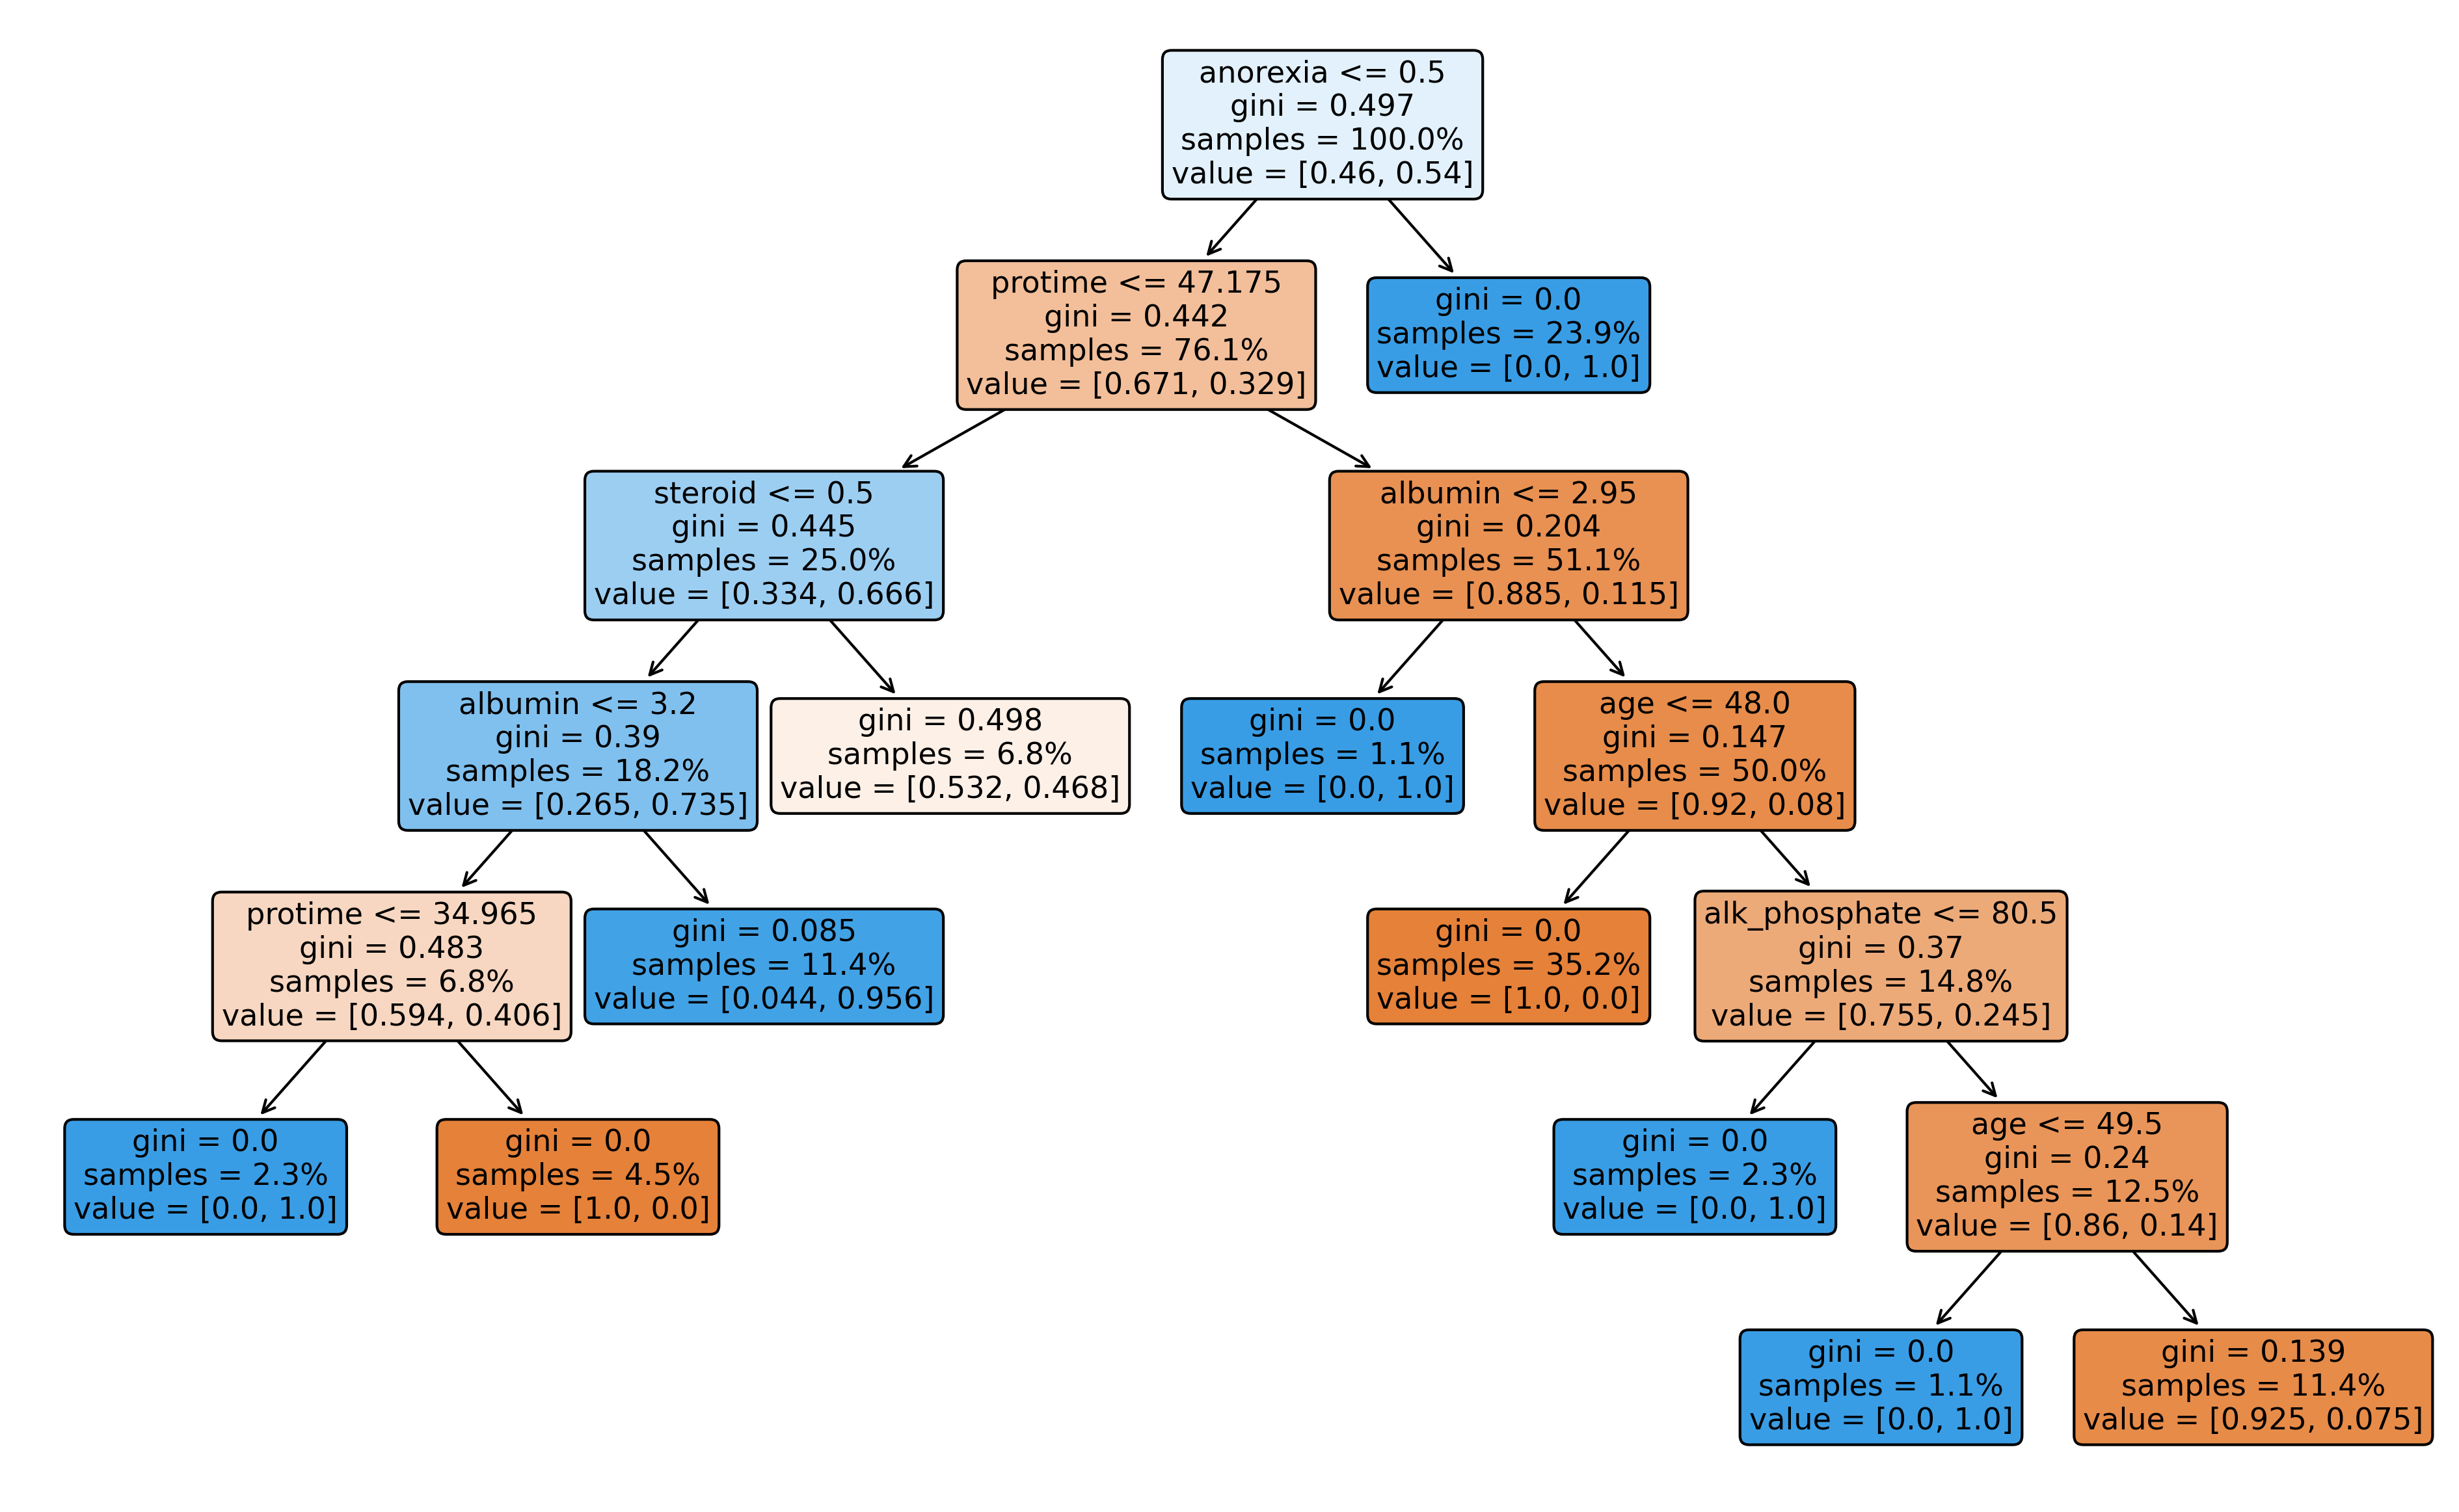

In [ ]:
from matplotlib import pyplot as plt

df = pd.read_excel('hepatitis_missforest.xlsx')

x = df.drop(['malaise'], axis=1) 
y = df['malaise'] 

pohon = RandomForestClassifier(n_estimators=100, 
                               max_leaf_nodes=10,
                               class_weight='balanced',
                               random_state=75)
pohon.fit(x, y.values.ravel())

plt.figure(figsize=(16,10), dpi=300)

_ = tree.plot_tree(pohon.estimators_[99], 
                   feature_names=x.columns,
                   proportion=True,
                   filled=True, 
                   rounded=True)

##Dataset

In [ ]:
hepatitis

,age,sex,steroid,antivirals,fatigue,malaise,anorexia,liver_big,liver_firm,spleen_palpable,spiders,ascites,varices,bilirubin,alk_phosphate,sgot,albumin,protime,histology,class
0,30,male,False,False,False,False,False,False,False,False,False,False,False,1.0,85.0,18.0,4.0,NaN,False,live
1,50,female,False,False,True,False,False,False,False,False,False,False,False,0.9,135.0,42.0,3.5,NaN,False,live
2,78,female,True,False,True,False,False,True,False,False,False,False,False,0.7,96.0,32.0,4.0,NaN,False,live
3,31,female,NaN,True,False,False,False,True,False,False,False,False,False,0.7,46.0,52.0,4.0,80.0,False,live
4,34,female,True,False,False,False,False,True,False,False,False,False,False,1.0,NaN,200.0,4.0,NaN,False,live
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,46,female,True,False,True,True,True,True,False,False,True,True,True,7.6,NaN,242.0,3.3,50.0,True,die
151,44,female,True,False,True,False,False,True,True,False,False,False,False,0.9,126.0,142.0,4.3,NaN,True,live
152,61,female,False,False,True,True,False,False,True,False,True,False,False,0.8,75.0,20.0,4.1,NaN,True,live
153,53,male,False,False,True,False,False,True,False,True,True,False,True,1.5,81.0,19.0,4.1,48.0,True,live


### Deskripsi dataset

In [ ]:
hepatitis.describe().T

,count,mean,std,min,25%,50%,75%,max
age,155.0,41.200000,12.565878,7.0,32.00,39.0,50.00,78.0
bilirubin,149.0,1.427517,1.212149,0.3,0.70,1.0,1.50,8.0
alk_phosphate,126.0,105.325397,51.508109,26.0,74.25,85.0,132.25,295.0
sgot,151.0,85.894040,89.650890,14.0,31.50,58.0,100.50,648.0
albumin,139.0,3.817266,0.651523,2.1,3.40,4.0,4.20,6.4
protime,88.0,61.852273,22.875244,0.0,46.00,61.0,76.25,100.0


###Tipe data pada dataset

In [ ]:
hepatitis.dtypes

age                  int64
sex                 object
steroid             object
antivirals            bool
fatigue             object
malaise             object
anorexia            object
liver_big           object
liver_firm          object
spleen_palpable     object
spiders             object
ascites             object
varices             object
bilirubin          float64
alk_phosphate      float64
sgot               float64
albumin            float64
protime            float64
histology             bool
class               object
dtype: object

###Cek jumlah missing value

In [ ]:
hepatitis.isnull().sum()

sex                 0
steroid             1
antivirals          0
fatigue             1
malaise             1
anorexia            1
liver_big          10
liver_firm         11
spleen_palpable     5
spiders             5
ascites             5
varices             5
histology           0
age                 0
bilirubin           6
alk_phosphate      29
sgot                4
albumin            16
protime            67
class               0
dtype: int64

In [ ]:
hepatitis.isnull().sum().sort_values(ascending=True)

sex                 0
age                 0
histology           0
class               0
antivirals          0
malaise             1
anorexia            1
steroid             1
fatigue             1
sgot                4
spleen_palpable     5
ascites             5
varices             5
spiders             5
bilirubin           6
liver_big          10
liver_firm         11
albumin            16
alk_phosphate      29
protime            67
dtype: int64

### Plot missing value

GridSpec(6, 6)

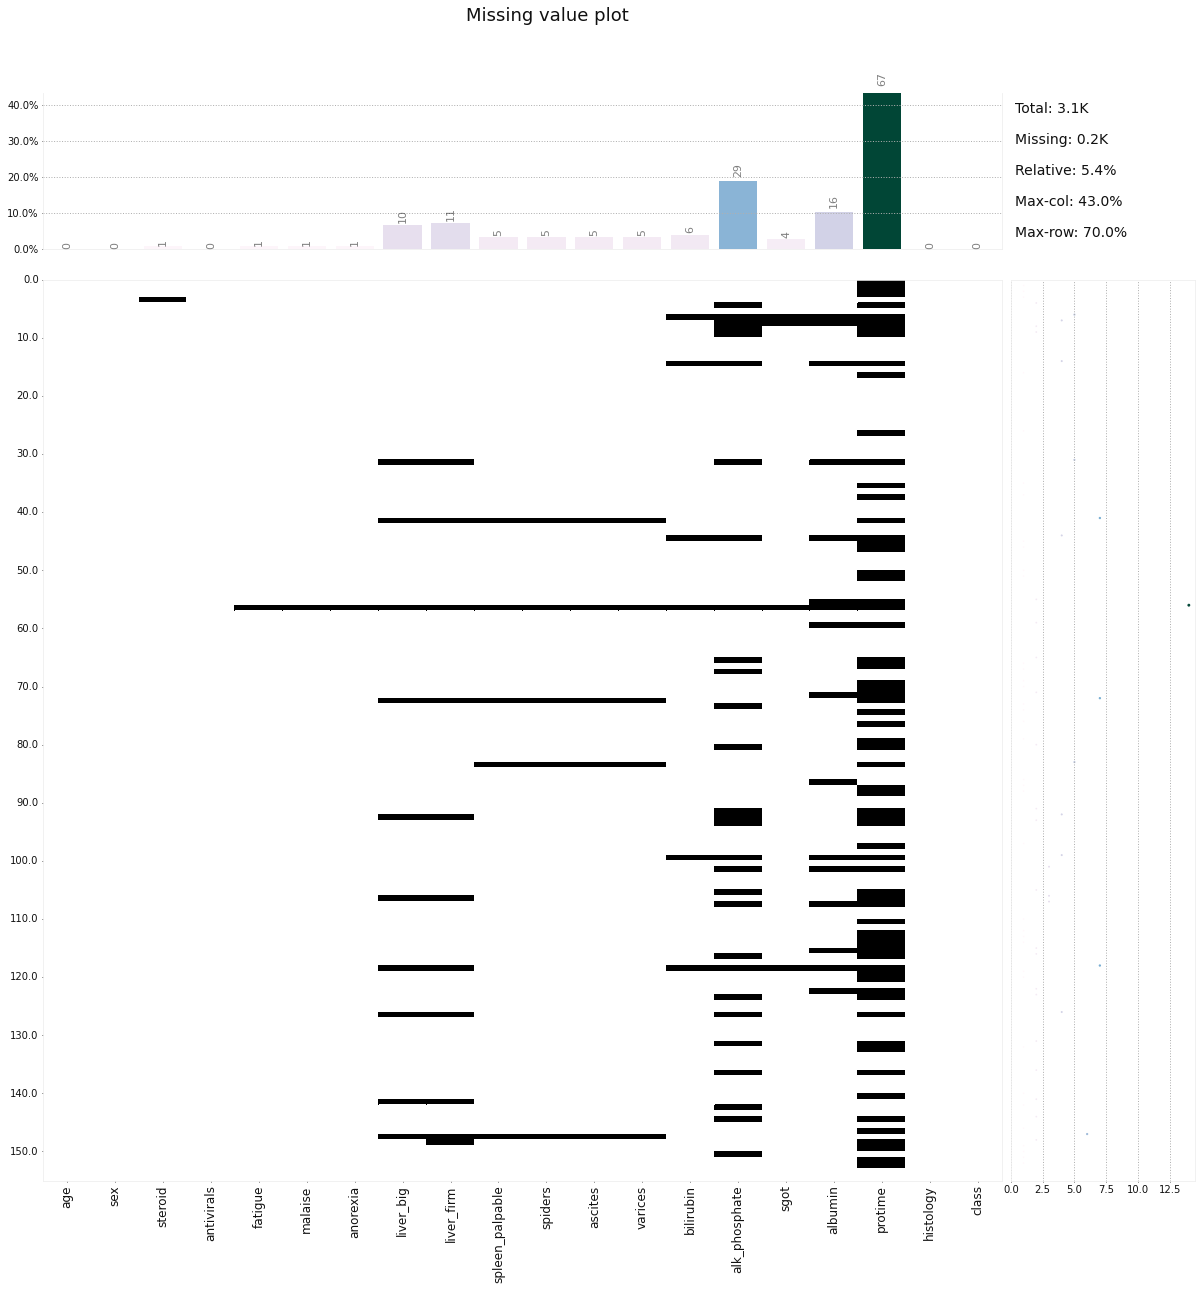

In [ ]:
klib.missingval_plot(hepatitis)

### Plot scatter

In [ ]:
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go
# Set notebook mode to work in offline
pyo.init_notebook_mode()
print('selesai')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
df = pd.read_excel('hepatitis_drop.xlsx')
# df = px.df.bilirubin()
fig = px.scatter(df, 
                 x='bilirubin', 
                 y='age', 
                 color='sex')
fig.show()

##Tabel preprocessing OneHotEncoder

In [ ]:
df_join = x_dropna.join(y_dropna)
df_join

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,class
3,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,31.0,0.7,46.0,52.0,4.0,80.0,live
5,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,34.0,0.9,95.0,28.0,4.0,75.0,live
10,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,39.0,1.3,78.0,30.0,4.4,85.0,live
11,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,32.0,1.0,59.0,249.0,3.7,54.0,live
12,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,41.0,0.9,81.0,60.0,3.9,52.0,live
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,49.0,1.4,85.0,70.0,3.5,35.0,die
145,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,31.0,1.2,75.0,173.0,4.2,54.0,live
147,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,70.0,1.7,109.0,528.0,2.8,35.0,die
153,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,53.0,1.5,81.0,19.0,4.1,48.0,live


##Tabel preprocessing OrdinalEncoder

In [ ]:
df_pre

,sex,steroid,antivirals,fatigue,malaise,anorexia,liver_big,liver_firm,spleen_palpable,spiders,ascites,varices,histology,age,bilirubin,alk_phosphate,sgot,albumin,protime,class
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,1.0,85.0,18.0,4.0,NaN,live
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.9,135.0,42.0,3.5,NaN,live
2,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,78.0,0.7,96.0,32.0,4.0,NaN,live
3,0.0,NaN,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,0.7,46.0,52.0,4.0,80.0,live
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,34.0,1.0,NaN,200.0,4.0,NaN,live
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,46.0,7.6,NaN,242.0,3.3,50.0,die
151,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,44.0,0.9,126.0,142.0,4.3,NaN,live
152,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,61.0,0.8,75.0,20.0,4.1,NaN,live
153,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,53.0,1.5,81.0,19.0,4.1,48.0,live


##Tabel drop missing value

In [ ]:
x_dropna

,sex,steroid,antivirals,fatigue,malaise,anorexia,liver_big,liver_firm,spleen_palpable,spiders,ascites,varices,histology,age,bilirubin,alk_phosphate,sgot,albumin,protime
5,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,34.0,0.9,95.0,28.0,4.0,75.0
10,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,39.0,1.3,78.0,30.0,4.4,85.0
11,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,32.0,1.0,59.0,249.0,3.7,54.0
12,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,41.0,0.9,81.0,60.0,3.9,52.0
13,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,30.0,2.2,57.0,144.0,4.9,78.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,45.0,1.3,85.0,44.0,4.2,85.0
143,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,49.0,1.4,85.0,70.0,3.5,35.0
145,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,31.0,1.2,75.0,173.0,4.2,54.0
153,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,53.0,1.5,81.0,19.0,4.1,48.0


##Tabel setelah diimputasi

In [ ]:
df_imputed

,sex,steroid,antivirals,fatigue,malaise,anorexia,liver_big,liver_firm,spleen_palpable,spiders,ascites,varices,histology,age,bilirubin,alk_phosphate,sgot,albumin,protime,class
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,1.0,85.00,18.0,4.0,87.53,live
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.9,135.00,42.0,3.5,53.62,live
2,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,78.0,0.7,96.00,32.0,4.0,74.54,live
3,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,0.7,46.00,52.0,4.0,80.00,live
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,34.0,1.0,74.47,200.0,4.0,69.14,live
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,46.0,7.6,131.98,242.0,3.3,50.00,die
151,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,44.0,0.9,126.00,142.0,4.3,65.08,live
152,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,61.0,0.8,75.00,20.0,4.1,81.78,live
153,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,53.0,1.5,81.00,19.0,4.1,48.00,live


##Cek missing value

In [ ]:
klib.missingval_plot(df_imputed)

No missing values found in the dataset.


In [ ]:
df_imputed.isnull().sum()

sex                0
steroid            0
antivirals         0
fatigue            0
malaise            0
anorexia           0
liver_big          0
liver_firm         0
spleen_palpable    0
spiders            0
ascites            0
varices            0
histology          0
age                0
bilirubin          0
alk_phosphate      0
sgot               0
albumin            0
protime            0
class              0
dtype: int64

##Cek hasil data

In [ ]:
with pd.ExcelWriter('/content/drive/MyDrive/dataset/output.xlsx') as writer:  
    hepatitis.to_excel(writer, sheet_name='dataset')
    df_pre.to_excel(writer, sheet_name='hasil preprocessing')
    x_dropna.to_excel(writer, sheet_name='hasil cleaning',)
    df_imputed.to_excel(writer, sheet_name='hasil imputasi')

In [ ]:
df_join = x_dropna.join(y_dropna)
df_join.to_excel('/content/drive/MyDrive/dataset/cleaning.xlsx')

In [ ]:
# Membaca dataset
hepatitis = pd.read_excel('hepatitis_pre.xlsx')

## menghapus kolom index
# hepatitis.drop(hepatitis.columns[0], axis=1, inplace=True)
## axis untuk menghapus kolom atau baris. 0 untuk baris dan 1 untuk kolom

# Variabel independen
x = hepatitis.drop (["class"], axis=1) #fitur kelas di drop untuk dijadikan target

# Variabel dependen
y = hepatitis ["class"] #fitur kelas dijadikan target dan dinyatakan dengan y

# fitur kategorikal dinyatakan kedalam cat_column
cat_column = ['sex','steroid','antivirals','fatigue','malaise','anorexia',
              'liver_big','liver_firm','spleen_palpable','spiders','ascites',
              'varices','histology']
cat_cols = []
for i in cat_column :
    cat_cols.append(x.columns.to_list().index(i))
# Mengambil index dari list cat_column dan dimasukkan ke cat_cols. Mengubah list cat_column menjadi index dan dimasukkan ke cat_cols

# Imputasi missforest
imputer = MissForest(max_iter=10, # iterasi maksimal sampai 10
                     n_estimators=100, # jumlah pohon yang akan digunakan
                     class_weight='balanced', # meningkatkan bobot kelas minoritas dan mengurangi bobot kelas mayoritas dalam menghitung prediksi
                     random_state=75) # berfungsi agar proses pelatihan model memperoleh hasil yang sama walaupun dijalankan berulang kali
x_imputed = imputer.fit_transform(x, cat_vars=cat_cols) # cat_vars berfungsi sebagai penentu fitur kategorikal pada dataset

# menyimpan data hasil imputasi ke csv
df_imputed = pd.DataFrame(x_imputed, columns=x.columns)
df_imputed['class'] = y
x_imp = df_imputed.drop(['class'], axis=1)
x_imp.to_excel('hepatitis_missforest.xlsx', index=False)

# Import train_test_split function
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(x_imp, y, test_size=0.9, random_state=75)
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(x_imp, y, test_size=0.8, random_state=75)
x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(x_imp, y, test_size=0.7, random_state=75)
x_train_4, x_test_4, y_train_4, y_test_4 = train_test_split(x_imp, y, test_size=0.6, random_state=75)
x_train_5, x_test_5, y_train_5, y_test_5 = train_test_split(x_imp, y, test_size=0.5, random_state=75)
x_train_6, x_test_6, y_train_6, y_test_6 = train_test_split(x_imp, y, test_size=0.4, random_state=75)
x_train_7, x_test_7, y_train_7, y_test_7 = train_test_split(x_imp, y, test_size=0.3, random_state=75)
x_train_8, x_test_8, y_train_8, y_test_8 = train_test_split(x_imp, y, test_size=0.2, random_state=75)
x_train_9, x_test_9, y_train_9, y_test_9 = train_test_split(x_imp, y, test_size=0.1, random_state=75)

# Mengaktifkan/memanggil/membuat fungsi klasifikasi Naive bayes
gnb = GaussianNB()

y_pred_1 = gnb.fit(x_train_1, y_train_1).predict(x_test_1)
y_pred_2 = gnb.fit(x_train_2, y_train_2).predict(x_test_2)
y_pred_3 = gnb.fit(x_train_3, y_train_3).predict(x_test_3)
y_pred_4 = gnb.fit(x_train_4, y_train_4).predict(x_test_4)
y_pred_5 = gnb.fit(x_train_5, y_train_5).predict(x_test_5)
y_pred_6 = gnb.fit(x_train_6, y_train_6).predict(x_test_6)
y_pred_7 = gnb.fit(x_train_7, y_train_7).predict(x_test_7)
y_pred_8 = gnb.fit(x_train_8, y_train_8).predict(x_test_8)
y_pred_9 = gnb.fit(x_train_9, y_train_9).predict(x_test_9)

# Menampilkan nilai akurasi dari klasifikasi naive bayes
print( )
print("Nilai akurasi komposisi 10:90 adalah {:.2f}%".format(metrics.accuracy_score(y_test_1, y_pred_1) * 100))
print("Nilai akurasi komposisi 20:80 adalah {:.2f}%".format(metrics.accuracy_score(y_test_2, y_pred_2) * 100))
print("Nilai akurasi komposisi 30:70 adalah {:.2f}%".format(metrics.accuracy_score(y_test_3, y_pred_3) * 100))
print("Nilai akurasi komposisi 40:80 adalah {:.2f}%".format(metrics.accuracy_score(y_test_4, y_pred_4) * 100))
print("Nilai akurasi komposisi 50:50 adalah {:.2f}%".format(metrics.accuracy_score(y_test_5, y_pred_5) * 100))
print("Nilai akurasi komposisi 60:40 adalah {:.2f}%".format(metrics.accuracy_score(y_test_6, y_pred_6) * 100))
print("Nilai akurasi komposisi 70:30 adalah {:.2f}%".format(metrics.accuracy_score(y_test_7, y_pred_7) * 100))
print("Nilai akurasi komposisi 80:20 adalah {:.2f}%".format(metrics.accuracy_score(y_test_8, y_pred_8) * 100))
print("Nilai akurasi komposisi 90:10 adalah {:.2f}%".format(metrics.accuracy_score(y_test_9, y_pred_9) * 100))

Iteration: 0
Iteration: 1
Iteration: 2

Nilai akurasi komposisi 10:90 adalah 77.86%
Nilai akurasi komposisi 20:80 adalah 81.45%
Nilai akurasi komposisi 30:70 adalah 85.32%
Nilai akurasi komposisi 40:80 adalah 86.02%
Nilai akurasi komposisi 50:50 adalah 83.33%
Nilai akurasi komposisi 60:40 adalah 90.32%
Nilai akurasi komposisi 70:30 adalah 93.62%
Nilai akurasi komposisi 80:20 adalah 90.32%
Nilai akurasi komposisi 90:10 adalah 93.75%


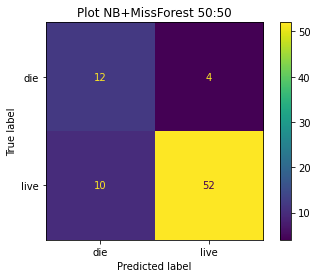

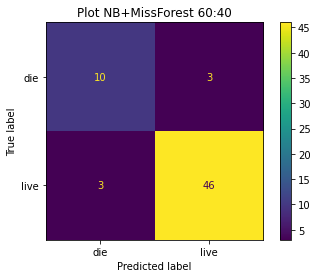

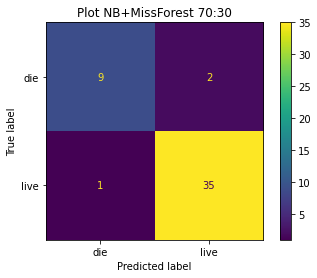

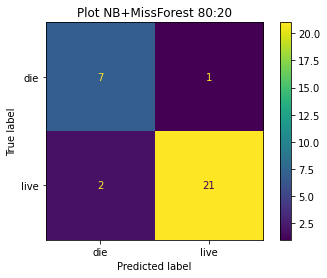

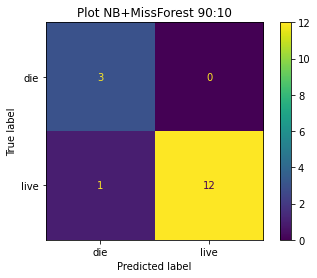

In [ ]:
disp_1 = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_test_1, y_pred_1), display_labels=modelnb.classes_)
disp_1.plot()
plt.title("Plot NB+MissForest 50:50")
plt.show()
print( )

disp_2 = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_test_2, y_pred_2), display_labels=modelnb.classes_)
disp_2.plot()
plt.title("Plot NB+MissForest 60:40")
plt.show()
print( )

disp_3 = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_test_3, y_pred_3), display_labels=modelnb.classes_)
disp_3.plot()
plt.title("Plot NB+MissForest 70:30")
plt.show()
print( )

disp_4 = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_test_4, y_pred_4), display_labels=modelnb.classes_)
disp_4.plot()
plt.title("Plot NB+MissForest 80:20")
plt.show()
print( )

disp_5 = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_test_5, y_pred_5), display_labels=modelnb.classes_)
disp_5.plot()
plt.title("Plot NB+MissForest 90:10")
plt.show()

In [ ]:
# score auc roc sken1
y_dec_1 = modelnb.fit(x_train_1, y_train_1).predict_proba(x_test_1)[:, 1]
fpr_1, tpr_1, thresholds_1 = metrics.roc_curve(y_test_1, y_dec_1, pos_label='live')
metrics.plot_roc_curve(modelnb, x_test_1, y_test_1)
plt.title("Score NB 50:50 adalah {:.2f}%".format(auc(fpr_1, tpr_1) * 100))
plt.show()

y_dec_2 = modelnb.fit(x_train_2, y_train_2).predict_proba(x_test_2)[:, 1]
fpr_2, tpr_2, thresholds_2 = metrics.roc_curve(y_test_2, y_dec_2, pos_label='live')
print( )
metrics.plot_roc_curve(modelnb, x_test_2, y_test_2)
plt.title("Score NB 60:40 adalah {:.2f}%".format(auc(fpr_2, tpr_2) * 100))
plt.show()

y_dec_3 = modelnb.fit(x_train_3, y_train_3).predict_proba(x_test_3)[:, 1]
fpr_3, tpr_3, thresholds_3 = metrics.roc_curve(y_test_3, y_dec_3, pos_label='live')
print( )
metrics.plot_roc_curve(modelnb, x_test_3, y_test_3)
plt.title("Score NB 70:30 adalah {:.2f}%".format(auc(fpr_3, tpr_3) * 100))
plt.show()

In [ ]:
# score auc roc sken2
y_dec_1 = modelnb.fit(x_train_1, y_train_1).predict_proba(x_test_1)[:, 1]
fpr_1, tpr_1, thresholds_1 = metrics.roc_curve(y_test_1, y_dec_1, pos_label='live')
metrics.plot_roc_curve(modelnb, x_test_1, y_test_1)
plt.title("Score NB+MF 50:50 adalah {:.2f}%".format(auc(fpr_1, tpr_1) * 100))
plt.show()

y_dec_2 = modelnb.fit(x_train_2, y_train_2).predict_proba(x_test_2)[:, 1]
fpr_2, tpr_2, thresholds_2 = metrics.roc_curve(y_test_2, y_dec_2, pos_label='live')
print( )
metrics.plot_roc_curve(modelnb, x_test_2, y_test_2)
plt.title("Score NB+MF 60:40 adalah {:.2f}%".format(auc(fpr_2, tpr_2) * 100))
plt.show()

y_dec_3 = modelnb.fit(x_train_3, y_train_3).predict_proba(x_test_3)[:, 1]
fpr_3, tpr_3, thresholds_3 = metrics.roc_curve(y_test_3, y_dec_3, pos_label='live')
print( )
metrics.plot_roc_curve(modelnb, x_test_3, y_test_3)
plt.title("Score NB+MF 70:30 adalah {:.2f}%".format(auc(fpr_3, tpr_3) * 100))
plt.show()

In [ ]:
# !pip install scikit-learn==0.22.2
# !pip install missingpy
# !pip install klib

In [ ]:
# import pyswarms as ps
# from pyswarms.single.global_best import GlobalBestPSO
# from pyswarms.utils.functions import single_obj as fx
# from sklearn.impute import SimpleImputer

In [ ]:
# print( )

# disp_4 = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_test_4, y_pred_4), display_labels=modelnb.classes_)
# disp_4.plot()
# plt.title("Plot NB 80:20")
# plt.show()
# print()

# disp_5 = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_test_5, y_pred_5), display_labels=modelnb.classes_)
# disp_5.plot()
# plt.title("Plot NB 90:10")
# plt.show()

In [ ]:
# Membaca dataset
df = pd.read_csv('hepatitis_csv.csv')
df.head()

,age,sex,steroid,antivirals,fatigue,malaise,anorexia,liver_big,liver_firm,spleen_palpable,spiders,ascites,varices,bilirubin,alk_phosphate,sgot,albumin,protime,histology,class
0,30,male,False,False,False,False,False,False,False,False,False,False,False,1.0,85.0,18.0,4.0,NaN,False,live
1,50,female,False,False,True,False,False,False,False,False,False,False,False,0.9,135.0,42.0,3.5,NaN,False,live
2,78,female,True,False,True,False,False,True,False,False,False,False,False,0.7,96.0,32.0,4.0,NaN,False,live
3,31,female,NaN,True,False,False,False,True,False,False,False,False,False,0.7,46.0,52.0,4.0,80.0,False,live
4,34,female,True,False,False,False,False,True,False,False,False,False,False,1.0,NaN,200.0,4.0,NaN,False,live


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              155 non-null    int64  
 1   sex              155 non-null    object 
 2   steroid          154 non-null    object 
 3   antivirals       155 non-null    bool   
 4   fatigue          154 non-null    object 
 5   malaise          154 non-null    object 
 6   anorexia         154 non-null    object 
 7   liver_big        145 non-null    object 
 8   liver_firm       144 non-null    object 
 9   spleen_palpable  150 non-null    object 
 10  spiders          150 non-null    object 
 11  ascites          150 non-null    object 
 12  varices          150 non-null    object 
 13  bilirubin        149 non-null    float64
 14  alk_phosphate    126 non-null    float64
 15  sgot             151 non-null    float64
 16  albumin          139 non-null    float64
 17  protime         

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,155.0,41.200000,12.565878,7.0,32.00,39.0,50.00,78.0
bilirubin,149.0,1.427517,1.212149,0.3,0.70,1.0,1.50,8.0
alk_phosphate,126.0,105.325397,51.508109,26.0,74.25,85.0,132.25,295.0
sgot,151.0,85.894040,89.650890,14.0,31.50,58.0,100.50,648.0
albumin,139.0,3.817266,0.651523,2.1,3.40,4.0,4.20,6.4
protime,88.0,61.852273,22.875244,0.0,46.00,61.0,76.25,100.0


GridSpec(6, 6)

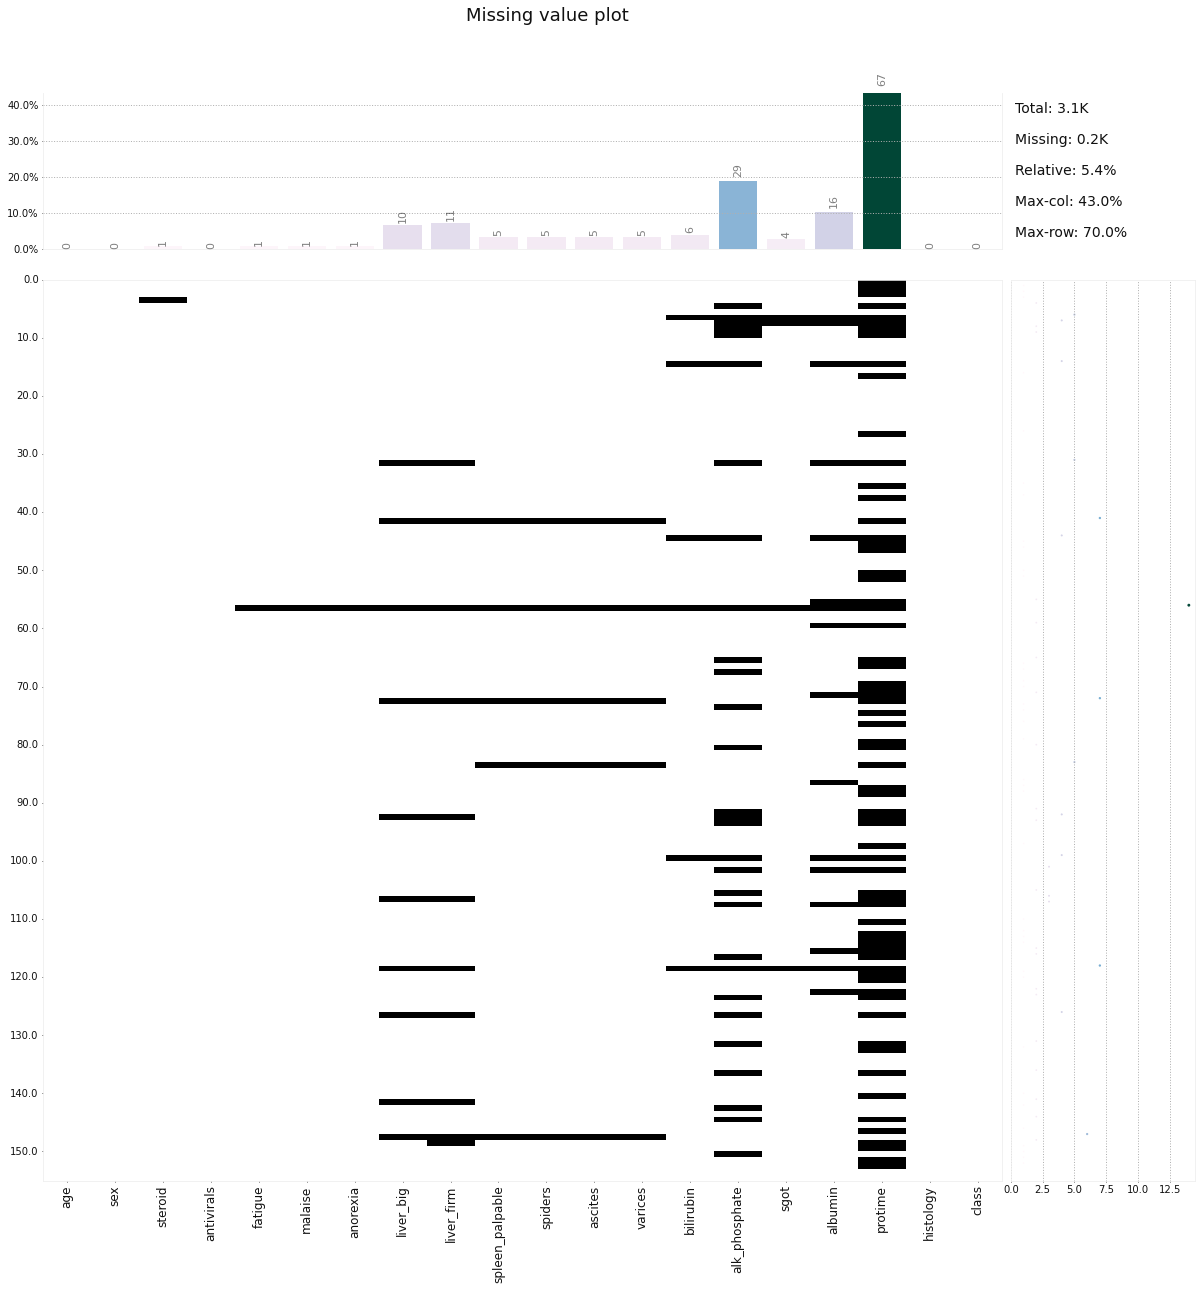

In [ ]:
import klib
klib.missingval_plot(df)

In [ ]:
dfm = pd.read_excel('hepatitis_pre.xlsx')
# df.drop(data.columns[0], axis=1, inplace=True)

x = dfm.drop (["class"], axis=1)
y = dfm ["class"]

cat_column = ['sex','steroid','antivirals','fatigue','malaise','anorexia',
              'liver_big','liver_firm','spleen_palpable','spiders','ascites',
              'varices','histology']
cat_cols = []
for i in cat_column :
    cat_cols.append(x.columns.to_list().index(i))

imputer = MissForest(max_iter=10,
                     n_estimators=100,
                     class_weight='balanced',
                     random_state=75)
x_imp = imputer.fit_transform(x, cat_vars=cat_cols)

Iteration: 0
Iteration: 1
Iteration: 2


In [ ]:
dfmm = pd.DataFrame(x_imp,columns=x.columns)
dfmm['class'] = y
dfmm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sex              155 non-null    float64
 1   steroid          155 non-null    float64
 2   antivirals       155 non-null    float64
 3   fatigue          155 non-null    float64
 4   malaise          155 non-null    float64
 5   anorexia         155 non-null    float64
 6   liver_big        155 non-null    float64
 7   liver_firm       155 non-null    float64
 8   spleen_palpable  155 non-null    float64
 9   spiders          155 non-null    float64
 10  ascites          155 non-null    float64
 11  varices          155 non-null    float64
 12  histology        155 non-null    float64
 13  age              155 non-null    float64
 14  bilirubin        155 non-null    float64
 15  alk_phosphate    155 non-null    float64
 16  sgot             155 non-null    float64
 17  albumin         

In [ ]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80 entries, 5 to 154
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              80 non-null     int64  
 1   sex              80 non-null     object 
 2   steroid          80 non-null     object 
 3   antivirals       80 non-null     bool   
 4   fatigue          80 non-null     object 
 5   malaise          80 non-null     object 
 6   anorexia         80 non-null     object 
 7   liver_big        80 non-null     object 
 8   liver_firm       80 non-null     object 
 9   spleen_palpable  80 non-null     object 
 10  spiders          80 non-null     object 
 11  ascites          80 non-null     object 
 12  varices          80 non-null     object 
 13  bilirubin        80 non-null     float64
 14  alk_phosphate    80 non-null     float64
 15  sgot             80 non-null     float64
 16  albumin          80 non-null     float64
 17  protime          

In [ ]:
df.columns

Index(['age', 'sex', 'steroid', 'antivirals', 'fatigue', 'malaise', 'anorexia',
       'liver_big', 'liver_firm', 'spleen_palpable', 'spiders', 'ascites',
       'varices', 'bilirubin', 'alk_phosphate', 'sgot', 'albumin', 'protime',
       'histology', 'class'],
      dtype='object')

In [ ]:
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go
# Set notebook mode to work in offline
pyo.init_notebook_mode()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
px.scatter(df, y='bilirubin',x='age', color='sex')

In [ ]:
import sklearn
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder

dfmm = df.apply(LabelEncoder().fit_transform)
dfmm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   sex              155 non-null    int64
 1   steroid          155 non-null    int64
 2   antivirals       155 non-null    int64
 3   fatigue          155 non-null    int64
 4   malaise          155 non-null    int64
 5   anorexia         155 non-null    int64
 6   liver_big        155 non-null    int64
 7   liver_firm       155 non-null    int64
 8   spleen_palpable  155 non-null    int64
 9   spiders          155 non-null    int64
 10  ascites          155 non-null    int64
 11  varices          155 non-null    int64
 12  histology        155 non-null    int64
 13  age              155 non-null    int64
 14  bilirubin        155 non-null    int64
 15  alk_phosphate    155 non-null    int64
 16  sgot             155 non-null    int64
 17  albumin          155 non-null    int64
 18  protime   

In [ ]:
_=klib.corr_plot(data=dfmm, target='class')

TypeError: ignored

In [ ]:
X=data1.drop(['class'], axis=1)

Y=data1['class']

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train,y_test = train_test_split(data1.drop(["class"], axis=1), y, test_size=0.1, random_state=75)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# RF=RandomForestClassifier()
GNB = GaussianNB()
model=GNB.fit(x_train, y_train)
y_pred=model.predict(x_test)
y_pred

array(['live', 'live', 'live', 'die', 'live', 'die', 'die', 'live',
       'live', 'die', 'live', 'live', 'live', 'live', 'live', 'live'],
      dtype='<U4')

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
print('Accuracy value is', accuracy_score(y_pred,y_test))

Accuracy value is 0.9375


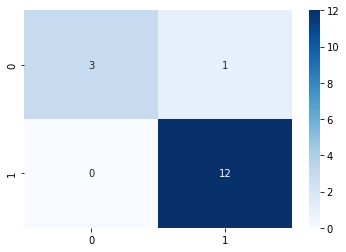

In [ ]:
import seaborn as sns
_=sns.heatmap(confusion_matrix(y_pred, y_test), annot=True, fmt='g', cmap='Blues')

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Mean Absolute Error (MAE):
mae = mean_absolute_error(y_test, y_pred)
print('MAE: ', mae)

# Mean Squared Error (MSE):
mse = mean_squared_error(y_test, y_pred)
print('MSE : ', mse)

# Root Mean Square Error (RMSE):
rmse = np.sqrt(mse)
print('RMSE : ', rmse)

# R-squared
r2 = r2_score(y_test, y_pred)
print('R2 : ',r2)

# Relative Absolute Error (RAE):
RAE = (np.sum(abs(y_test - y_pred)))/(np.sum(abs(y_test - np.mean(y_test))))
print('RAE : ',RAE)
print( )

# Relative Squared Error (RSE):
RSE = np.sum(np.square(y_test - y_pred)) / np.sum(np.square(y_test - np.mean(y_test)))
print('RSE : ',RSE)
print( )

# Mean Absolute Percentage Error (MAPE):
MAPE = np.mean(np.abs(y_test - y_pred)) * 100
print('MAPE : ', round(MAPE,2), '%', sep='')
print( )

# Mean Percentage Error (MPE):
MPE = np.mean(y_test - y_pred) * 100
print('MAPE : ', round(MPE,2), '%', sep='')
print( )

ValueError: ignored

##Mixed Naive Bayes

In [ ]:
!pip install mixed-naive-bayes

from mixed_naive_bayes import MixedNB

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### MixedNB

In [ ]:
!pip install mixed_naive_bayes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df = pd.read_excel('cleaning x.xlsx')
df.drop(df.columns[0], axis=1, inplace=True)

x = df.drop (['class'], axis=1)
y = df['class']

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
xl = x[['sex','steroid','antivirals','fatigue','malaise','anorexia','liver_big',
        'liver_firm','spleen_palpable','spiders','ascites','varices','histology'
        ]].apply(LabelEncoder().fit_transform).copy()
xl = xl.join(x[['age','bilirubin','alk_phosphate','sgot','albumin','protime']])
yl = le.fit_transform(y)

x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(xl, yl, test_size=0.5, stratify=yl, random_state=75)
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(xl, yl, test_size=0.4, stratify=yl, random_state=75)
x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(xl, yl, test_size=0.3, stratify=yl, random_state=75)
x_train_4, x_test_4, y_train_4, y_test_4 = train_test_split(xl, yl, test_size=0.2, stratify=yl, random_state=75)
x_train_5, x_test_5, y_train_5, y_test_5 = train_test_split(xl, yl, test_size=0.1, stratify=yl, random_state=75)

from mixed_naive_bayes import MixedNB
mnb = MixedNB(categorical_features=[0,1,2,3,4,5,6,7,8,9,10,11,12])

y_pred_1 = mnb.fit(x_train_1, y_train_1).predict(x_test_1)
y_pred_2 = mnb.fit(x_train_2, y_train_2).predict(x_test_2)
y_pred_3 = mnb.fit(x_train_3, y_train_3).predict(x_test_3)
y_pred_4 = mnb.fit(x_train_4, y_train_4).predict(x_test_4)
y_pred_5 = mnb.fit(x_train_5, y_train_5).predict(x_test_5)

print("Nilai akurasi komposisi 50:50 adalah {:.2f}%".format(metrics.accuracy_score(y_test_1, y_pred_1) * 100))
print("Nilai akurasi komposisi 60:40 adalah {:.2f}%".format(metrics.accuracy_score(y_test_2, y_pred_2) * 100))
print("Nilai akurasi komposisi 70:30 adalah {:.2f}%".format(metrics.accuracy_score(y_test_3, y_pred_3) * 100))
print("Nilai akurasi komposisi 80:20 adalah {:.2f}%".format(metrics.accuracy_score(y_test_4, y_pred_4) * 100))
print("Nilai akurasi komposisi 90:10 adalah {:.2f}%".format(metrics.accuracy_score(y_test_5, y_pred_5) * 100))

Nilai akurasi komposisi 50:50 adalah 85.00%
Nilai akurasi komposisi 60:40 adalah 93.75%
Nilai akurasi komposisi 70:30 adalah 91.67%
Nilai akurasi komposisi 80:20 adalah 93.75%
Nilai akurasi komposisi 90:10 adalah 100.00%


#### Confusion Matrix

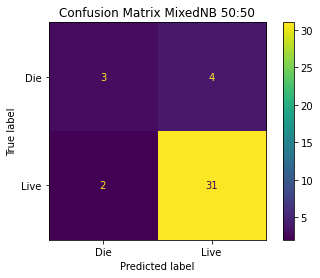

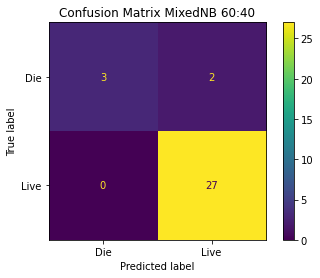

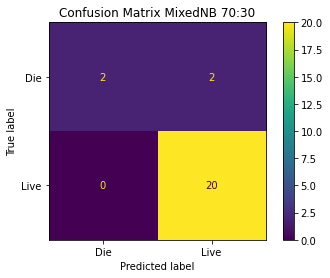

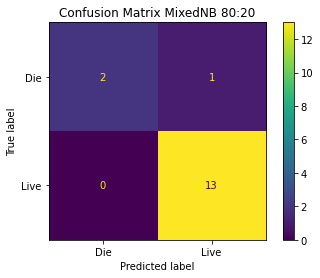

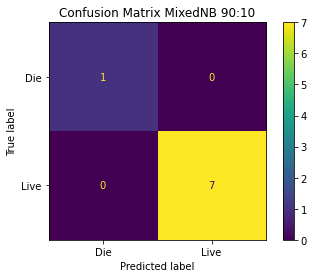

In [ ]:
list_class = ['Die','Live']

disp_1 = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix
                                        (y_test_1, y_pred_1), 
                                        display_labels=list_class)
disp_1.plot()
plt.title("Confusion Matrix MixedNB 50:50")
plt.show()
print ( )

disp_2 = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix
                                        (y_test_2, y_pred_2), 
                                        display_labels=list_class)
disp_2.plot()
plt.title("Confusion Matrix MixedNB 60:40")
plt.show()
print ( )

disp_3 = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix
                                        (y_test_3, y_pred_3), 
                                        display_labels=list_class)
disp_3.plot()
plt.title("Confusion Matrix MixedNB 70:30")
plt.show()
print ( )

disp_4 = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix
                                        (y_test_4, y_pred_4), 
                                        display_labels=list_class)
disp_4.plot()
plt.title("Confusion Matrix MixedNB 80:20")
plt.show()
print ( )

disp_5 = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix
                                        (y_test_5, y_pred_5), 
                                        display_labels=list_class)
disp_5.plot()
plt.title("Confusion Matrix MixedNB 90:10")
plt.show()

#### Classification Report

In [ ]:
print('Clasification report NB 50:50')
print(classification_report(y_test_1, y_pred_1))
print('\nClasification report NB 60:40')
print(classification_report(y_test_2, y_pred_2))
print('\nClasification report NB 70:30')
print(classification_report(y_test_3, y_pred_3))
print('\nClasification report NB 80:20')
print(classification_report(y_test_4, y_pred_4))
print('\nClasification report NB 90:10')
print(classification_report(y_test_5, y_pred_5))

Clasification report NB 50:50
              precision    recall  f1-score   support

           0       0.50      0.57      0.53         7
           1       0.91      0.88      0.89        33

    accuracy                           0.82        40
   macro avg       0.70      0.73      0.71        40
weighted avg       0.84      0.82      0.83        40


Clasification report NB 60:40
              precision    recall  f1-score   support

           0       0.50      0.50      0.50         6
           1       0.88      0.88      0.88        26

    accuracy                           0.81        32
   macro avg       0.69      0.69      0.69        32
weighted avg       0.81      0.81      0.81        32


Clasification report NB 70:30
              precision    recall  f1-score   support

           0       0.40      0.50      0.44         4
           1       0.89      0.85      0.87        20

    accuracy                           0.79        24
   macro avg       0.65      0.68   

#### Plot AUC ROC 

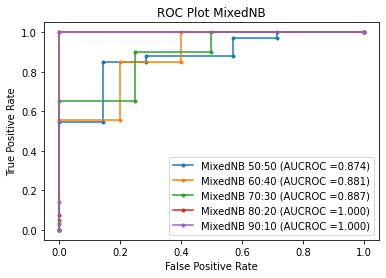

In [ ]:
y_dec_1 = mnb.fit(x_train_1, y_train_1).predict_proba(x_test_1)[:, 1]
y_dec_2 = mnb.fit(x_train_2, y_train_2).predict_proba(x_test_2)[:, 1]
y_dec_3 = mnb.fit(x_train_3, y_train_3).predict_proba(x_test_3)[:, 1]
y_dec_4 = mnb.fit(x_train_4, y_train_4).predict_proba(x_test_4)[:, 1]
y_dec_5 = mnb.fit(x_train_5, y_train_5).predict_proba(x_test_5)[:, 1]

fpr_1, tpr_1, thresholds_1 = metrics.roc_curve(y_test_1, y_dec_1, pos_label=1)
fpr_2, tpr_2, thresholds_2 = metrics.roc_curve(y_test_2, y_dec_2, pos_label=1)
fpr_3, tpr_3, thresholds_3 = metrics.roc_curve(y_test_3, y_dec_3, pos_label=1)
fpr_4, tpr_4, thresholds_4 = metrics.roc_curve(y_test_4, y_dec_4, pos_label=1)
fpr_5, tpr_5, thresholds_5 = metrics.roc_curve(y_test_5, y_dec_5, pos_label=1)

plt.plot(fpr_1, tpr_1, marker='.', label="MixedNB 50:50 (AUCROC ={:.3f})".format(auc(fpr_1, tpr_1)))
plt.plot(fpr_2, tpr_2, marker='.', label="MixedNB 60:40 (AUCROC ={:.3f})".format(auc(fpr_2, tpr_2)))
plt.plot(fpr_3, tpr_3, marker='.', label="MixedNB 70:30 (AUCROC ={:.3f})".format(auc(fpr_3, tpr_3)))
plt.plot(fpr_4, tpr_4, marker='.', label="MixedNB 80:20 (AUCROC ={:.3f})".format(auc(fpr_4, tpr_4)))
plt.plot(fpr_5, tpr_5, marker='.', label="MixedNB 90:10 (AUCROC ={:.3f})".format(auc(fpr_5, tpr_5)))

plt.title('ROC Plot MixedNB')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

#### Balanced Accuracy

In [ ]:
print("Balanced Accuracy 50:50 adalah {:.2f}%".format(metrics.balanced_accuracy_score(y_test_1, y_pred_1)*100))
print("Balanced Accuracy 60:40 adalah {:.2f}%".format(metrics.balanced_accuracy_score(y_test_2, y_pred_2)*100))
print("Balanced Accuracy 70:30 adalah {:.2f}%".format(metrics.balanced_accuracy_score(y_test_3, y_pred_3)*100))
print("Balanced Accuracy 80:20 adalah {:.2f}%".format(metrics.balanced_accuracy_score(y_test_4, y_pred_4)*100))
print("Balanced Accuracy 90:10 adalah {:.2f}%".format(metrics.balanced_accuracy_score(y_test_5, y_pred_5)*100))

Balanced Accuracy 50:50 adalah 68.40%
Balanced Accuracy 60:40 adalah 80.00%
Balanced Accuracy 70:30 adalah 75.00%
Balanced Accuracy 80:20 adalah 83.33%
Balanced Accuracy 90:10 adalah 100.00%


### MixedNB + MF

In [ ]:
df = pd.read_excel('hepatitis_pres.xlsx')
df.drop(df.columns[0], axis=1, inplace=True)

x = df.drop (['class'], axis=1)
y = df['class']

x_imp = x
x_imp.to_excel('hepatitis_missforest.xlsx', index=False)

imputer = MissForest(max_iter=10,
                     n_estimators=100,
                     class_weight='balanced',
                     random_state=75)
x_imp = imputer.fit_transform(x)

df_imp = pd.DataFrame(x_imp, columns=x.columns)
df_imp['class'] = y
x_imp = df_imp.drop(['class'], axis=1)
x_imp.to_excel('imputed_missforest.xlsx', index=False)

x_train_6, x_test_6, y_train_6, y_test_6 = train_test_split(x_imp, y, test_size=0.5, stratify=y, random_state=75)
x_train_7, x_test_7, y_train_7, y_test_7 = train_test_split(x_imp, y, test_size=0.4, stratify=y, random_state=75)
x_train_8, x_test_8, y_train_8, y_test_8 = train_test_split(x_imp, y, test_size=0.3, stratify=y, random_state=75)
x_train_9, x_test_9, y_train_9, y_test_9 = train_test_split(x_imp, y, test_size=0.2, stratify=y, random_state=75)
x_train_10, x_test_10, y_train_10, y_test_10 = train_test_split(x_imp, y, test_size=0.1, stratify=y, random_state=75)

mnb = MixedNB()

y_pred_6 = mnb.fit(x_train_6, y_train_6).predict(x_test_6)
y_pred_7 = mnb.fit(x_train_7, y_train_7).predict(x_test_7)
y_pred_8 = mnb.fit(x_train_8, y_train_8).predict(x_test_8)
y_pred_9 = mnb.fit(x_train_9, y_train_9).predict(x_test_9)
y_pred_10 = mnb.fit(x_train_10, y_train_10).predict(x_test_10)

print( )
print("Nilai akurasi komposisi 50:50 adalah {:.2f}%".format(metrics.accuracy_score(y_test_6, y_pred_6) * 100))
print("Nilai akurasi komposisi 60:40 adalah {:.2f}%".format(metrics.accuracy_score(y_test_7, y_pred_7) * 100))
print("Nilai akurasi komposisi 70:30 adalah {:.2f}%".format(metrics.accuracy_score(y_test_8, y_pred_8) * 100))
print("Nilai akurasi komposisi 80:20 adalah {:.2f}%".format(metrics.accuracy_score(y_test_9, y_pred_9) * 100))
print("Nilai akurasi komposisi 90:10 adalah {:.2f}%".format(metrics.accuracy_score(y_test_10, y_pred_10) * 100))

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3

Nilai akurasi komposisi 50:50 adalah 83.33%
Nilai akurasi komposisi 60:40 adalah 82.26%
Nilai akurasi komposisi 70:30 adalah 80.85%
Nilai akurasi komposisi 80:20 adalah 83.87%
Nilai akurasi komposisi 90:10 adalah 81.25%


#### Confusion Matrix

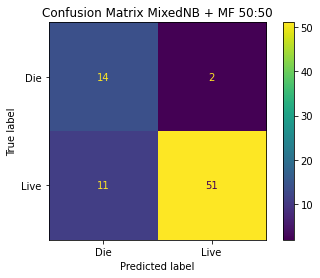

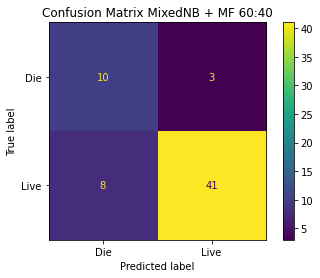

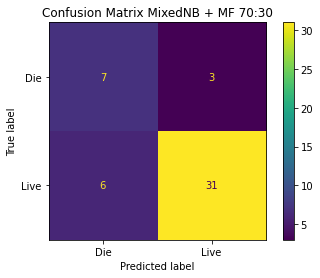

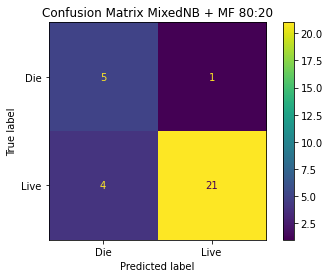

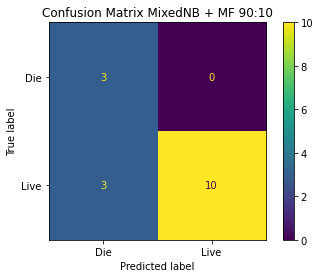

In [ ]:
list_class = ['Die','Live']

disp_6 = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix
                                        (y_test_6, y_pred_6), 
                                        display_labels=list_class)
disp_6.plot()
plt.title("Confusion Matrix MixedNB + MF 50:50")
plt.show()
print ( )

disp_7 = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix
                                        (y_test_7, y_pred_7), 
                                        display_labels=list_class)
disp_7.plot()
plt.title("Confusion Matrix MixedNB + MF 60:40")
plt.show()
print ( )

disp_8 = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix
                                        (y_test_8, y_pred_8), 
                                        display_labels=list_class)
disp_8.plot()
plt.title("Confusion Matrix MixedNB + MF 70:30")
plt.show()
print ( )

disp_9 = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix
                                        (y_test_9, y_pred_9), 
                                        display_labels=list_class)
disp_9.plot()
plt.title("Confusion Matrix MixedNB + MF 80:20")
plt.show()
print ( )

disp_10 = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix
                                         (y_test_10, y_pred_10), 
                                         display_labels=list_class)
disp_10.plot()
plt.title("Confusion Matrix MixedNB + MF 90:10")
plt.show()

#### Classification Report

In [ ]:
print('Clasification report NB 50:50')
print(classification_report(y_test_6, y_pred_6))
print('\nClasification report NB 60:40')
print(classification_report(y_test_7, y_pred_7))
print('\nClasification report NB 70:30')
print(classification_report(y_test_8, y_pred_8))
print('\nClasification report NB 80:20')
print(classification_report(y_test_9, y_pred_9))
print('\nClasification report NB 90:10')
print(classification_report(y_test_10, y_pred_10))

Clasification report NB 50:50
              precision    recall  f1-score   support

           0       0.56      0.88      0.68        16
           1       0.96      0.82      0.89        62

    accuracy                           0.83        78
   macro avg       0.76      0.85      0.78        78
weighted avg       0.88      0.83      0.85        78


Clasification report NB 60:40
              precision    recall  f1-score   support

           0       0.56      0.77      0.65        13
           1       0.93      0.84      0.88        49

    accuracy                           0.82        62
   macro avg       0.74      0.80      0.76        62
weighted avg       0.85      0.82      0.83        62


Clasification report NB 70:30
              precision    recall  f1-score   support

           0       0.54      0.70      0.61        10
           1       0.91      0.84      0.87        37

    accuracy                           0.81        47
   macro avg       0.73      0.77   

#### Plot AUC ROC

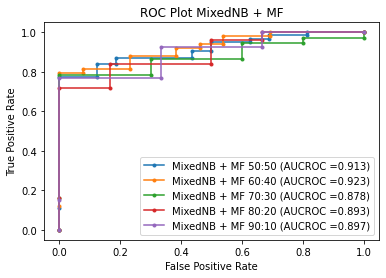

In [ ]:
y_dec_6 = mnb.fit(x_train_6, y_train_6).predict_proba(x_test_6)[:, 1]
y_dec_7 = mnb.fit(x_train_7, y_train_7).predict_proba(x_test_7)[:, 1]
y_dec_8 = mnb.fit(x_train_8, y_train_8).predict_proba(x_test_8)[:, 1]
y_dec_9 = mnb.fit(x_train_9, y_train_9).predict_proba(x_test_9)[:, 1]
y_dec_10 = mnb.fit(x_train_10, y_train_10).predict_proba(x_test_10)[:, 1]

fpr_6, tpr_6, thresholds_6 = metrics.roc_curve(y_test_6, y_dec_6, pos_label=1)
fpr_7, tpr_7, thresholds_7 = metrics.roc_curve(y_test_7, y_dec_7, pos_label=1)
fpr_8, tpr_8, thresholds_8 = metrics.roc_curve(y_test_8, y_dec_8, pos_label=1)
fpr_9, tpr_9, thresholds_9 = metrics.roc_curve(y_test_9, y_dec_9, pos_label=1)
fpr_10, tpr_10, thresholds_10 = metrics.roc_curve(y_test_10, y_dec_10, pos_label=1)

plt.plot(fpr_6, tpr_6, marker='.', label="MixedNB + MF 50:50 (AUCROC ={:.3f})".format(auc(fpr_6, tpr_6)))
plt.plot(fpr_7, tpr_7, marker='.', label="MixedNB + MF 60:40 (AUCROC ={:.3f})".format(auc(fpr_7, tpr_7)))
plt.plot(fpr_8, tpr_8, marker='.', label="MixedNB + MF 70:30 (AUCROC ={:.3f})".format(auc(fpr_8, tpr_8)))
plt.plot(fpr_9, tpr_9, marker='.', label="MixedNB + MF 80:20 (AUCROC ={:.3f})".format(auc(fpr_9, tpr_9)))
plt.plot(fpr_10, tpr_10, marker='.', label="MixedNB + MF 90:10 (AUCROC ={:.3f})".format(auc(fpr_10, tpr_10)))

plt.title('ROC Plot MixedNB + MF')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

#### Balanced Accuracy

In [ ]:
print("Balanced Accuracy 50:50 adalah {:.2f}%".format(metrics.balanced_accuracy_score(y_test_6, y_pred_6)*100))
print("Balanced Accuracy 60:40 adalah {:.2f}%".format(metrics.balanced_accuracy_score(y_test_7, y_pred_7)*100))
print("Balanced Accuracy 70:30 adalah {:.2f}%".format(metrics.balanced_accuracy_score(y_test_8, y_pred_8)*100))
print("Balanced Accuracy 80:20 adalah {:.2f}%".format(metrics.balanced_accuracy_score(y_test_9, y_pred_9)*100))
print("Balanced Accuracy 90:10 adalah {:.2f}%".format(metrics.balanced_accuracy_score(y_test_10, y_pred_10)*100))

Balanced Accuracy 50:50 adalah 84.88%
Balanced Accuracy 60:40 adalah 80.30%
Balanced Accuracy 70:30 adalah 76.89%
Balanced Accuracy 80:20 adalah 83.67%
Balanced Accuracy 90:10 adalah 88.46%
